<a href="https://colab.research.google.com/github/abulmeez/ML_Projects/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
from medmnist import OrganAMNIST

# **Task 1: Acquire the data**

In [ ]:
# load the train and test set
train_dataset = OrganAMNIST(split="train")
train_dataset_x = train_dataset.imgs.astype(np.float32)
train_y = train_dataset.labels.astype(np.int64)

val_dataset = OrganAMNIST(split="val")
val_dataset_x = val_dataset.imgs.astype(np.float32)
val_y = val_dataset.labels.astype(np.int64)

test_dataset = OrganAMNIST(split="test")
test_dataset_x = test_dataset.imgs.astype(np.float32)
test_y = test_dataset.labels.astype(np.int64)

# flatten
train_x = train_dataset_x.reshape(-1, 28 * 28)
test_x = test_dataset_x.reshape(-1, 28 * 28)
val_x = val_dataset_x.reshape(-1, 28 * 28)
if train_y.ndim == 2:
    train_y = train_y.flatten()
if test_y.ndim == 2:
    test_y = test_y.flatten()
if val_y.ndim == 2:
    val_y = val_y.flatten()

train_x_128 = np.array([np.resize(img, (128, 128)).flatten() for img in train_dataset.imgs])
test_x_128 = np.array([np.resize(img, (128, 128)).flatten() for img in test_dataset.imgs])
val_x_128 = np.array([np.resize(img, (128, 128)).flatten() for img in val_dataset.imgs])
print("28x28:", train_x.shape)
print("128x128:", train_x_128.shape)

# unnormalized data
train_x_unnormalized = train_x
val_x_unnormalized = val_x
test_x_unnormalized = test_x

# normalize
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)
# train_x_128 = scaler.fit_transform(train_x_128)
# test_x_128 = scaler.transform(test_x_128)
mean = np.mean(train_x)
std = np.std(train_x)
train_x = (train_x - mean) / std
val_x = (val_x - mean) / std
test_x = (test_x - mean) / std

mean_128 = np.mean(train_x_128)
std_128 = np.std(train_x_128)
train_x_128 = (train_x_128 - mean_128) / std_128
val_x_128 = (val_x_128 - mean_128) / std_128
test_x_128 = (test_x_128 - mean_128) / std_128

unique_classes = np.unique(train_y)
num_classes = len(unique_classes)
print("y shape: ", train_y.shape)
print("Number of classes:", num_classes)
print("Calculated Mean:", mean)
print("Calculated Std Dev:", std)


28x28: (34561, 784)
128x128: (34561, 16384)
y shape:  (34561,)
Number of classes: 11
Calculated Mean: 119.34719
Calculated Std Dev: 75.84229


* **dataset**

    OrganAMNIST is a medical imaging dataset(part of MedMNIST). It contains grayscale images representing different organs, categorized into 11 classes. Its mean value (119.35) is close to the middle of the range (0–255), which suggests that the images are not too dark or to bright[1]. With a standard deviation of 75.84, the pixel intensities are fairly spread out. This indicates that the dataset has moderate to high contrast[2].With normamlization, it will be easier for the model to learn consistent features.

* **references**

    [1] S. Schmid, “Image Intensity Normalization in Medical Imaging,” Medium, Sep. 01, 2023. https://medium.com/@susanne.schmid/image-normalization-in-medical-imaging-f586c8526bd1

    [2] R. Keim, “Understanding Contrast, Histograms, and Standard Deviation in Digital Imagery - Technical Articles,” www.allaboutcircuits.com, Sep. 28, 2020. https://www.allaboutcircuits.com/technical-articles/understanding-contrast-histograms-and-standard-deviation-in-digital-imagery/
‌
‌

# **Task 2: Implement a Multilayer Perceptron**

In [ ]:
"-----------------------------------------------------------------MLP--------------------------------------------------------------------"
class MLP:
    def __init__(self,
                 lr,
                 activation_func, # h
                 activation_func_grad, # h'
                 initializer, # initialization function
                 L = 1, # number of hidden layers
                 M = 256, # number of neurons in each layer
                 lambda_L1 = 0.0,
                 lambda_L2 = 0.0,
                 record = False):
        self.lr = lr
        self.activation_func = activation_func
        self.activation_func_grad = activation_func_grad
        self.initializer = initializer
        self.L = L
        self.M = M
        self.lambda_L1 = lambda_L1
        self.lambda_L2 = lambda_L2
        self.record = record
        self.loss = []
        self.train_performance = []
        self.test_performance = []

    def fit(self, x, y, max_iter=1e3, epsilon=1e-8, tolerance=1e-8, batch_size=1024, patient_enough=100, is_128x128=False):
        N, D = x.shape
        num_batches = N // batch_size
        y = one_hot(y.astype(int))
        N, C = y.shape # C is the number of classes
        self.w = []
        self.b = []
        self.z = [] # z: (N, M), stores the neurons in each layer
        self.init_weight_bias(D, C)

        iter_counter = 0
        patience_counter = 0
        norms = np.array([np.inf])
        loss_min = np.inf
        w_optimal, b_optimal = [np.zeros_like(w) for w in self.w], [np.zeros_like(b) for b in self.b]   # initialize W_optimal and B_optimal

        self.training_time = 0
        start_time = time.time()
        while np.any(norms > epsilon) and iter_counter < max_iter:
            for batch_iter in range(num_batches):
                x_batch, y_batch = get_mini_batch(batch_iter, x, y, batch_size, N)
                self.forward_prop(x_batch) # calculate neurons in each layer (z)
                grad_w, grad_b = self.backward_prop(x_batch, y_batch) # calculate gradients of weights and biases
                for layer in range(self.L + 1):
                    self.w[layer] -= self.lr * grad_w[layer]
                    self.b[layer] -= self.lr * grad_b[layer]
                norms = []
                for g in grad_w + grad_b:
                    norms.append(np.linalg.norm(g))
                norms = np.array(norms)
                iter_counter += 1

                loss = self.compute_loss(self.z[-1], y_batch)
                if loss < loss_min or loss > tolerance:
                    loss_min = loss
                    patience_counter = 0
                    w_optimal, b_optimal = self.w, self.b
                if patience_counter > patient_enough and loss < tolerance:
                    self.w, self.b = w_optimal, b_optimal
                    break
                patience_counter += 1

                if self.record:
                    if iter_counter % 100 == 0:
                        if is_128x128:
                            train_performance = evaluate_acc(train_y, self.predict(train_x_128))
                            test_performance = evaluate_acc(val_y, self.predict(val_x_128))
                        else:
                            train_performance = evaluate_acc(train_y, self.predict(train_x))
                            test_performance = evaluate_acc(val_y, self.predict(val_x))
                        self.loss.append(loss)
                        self.train_performance.append(train_performance)
                        self.test_performance.append(test_performance)
        end_time = time.time()
        self.training_time = end_time - start_time

    def init_weight_bias(self, D, C):
        if self.L == 0:
            # initialize weights and biases for output layer when no hidden layer
            self.w.append(self.initializer((D, C)))
            self.b.append(self.initializer((1, C), bias=True))
            return self
        for layer in range(self.L + 1):
            if layer == 0:
                # from input layer to the first hidden layer: w (D, M)
                self.w.append(self.initializer((D, self.M)))
                self.b.append(self.initializer((1, self.M), bias=True))
            elif layer == self.L:
                # the output layer: w (M, C)
                self.w.append(self.initializer((self.M, C)))
                self.b.append(self.initializer((1, C), bias=True))
            else:
                # other hidden layers: w (M, M)
                self.w.append(self.initializer((self.M, self.M)))
                self.b.append(self.initializer((1, self.M), bias=True))
        return self # enable method chaining

    def forward_prop(self, x):
        if self.L == 0:
            z = log_softmax(np.dot(x, self.w[0]) + self.b[0]) # using log_softmax for output layer
            z = np.exp(z)
            self.z = z
            return self
        zs = []
        for layer in range(self.L + 1):
            if layer == 0:
                z = self.activation_func(np.dot(x, self.w[0]) + self.b[0])
            elif layer == self.L:
                z = log_softmax(np.dot(zs[-1], self.w[self.L]) + self.b[self.L]) # using log_softmax for output layer
                z = np.exp(z)
            else:
                z = self.activation_func(np.dot(zs[-1], self.w[layer]) + self.b[layer])
            zs.append(z)
        self.z = zs
        return self

    def backward_prop(self, x, y):
        N = x.shape[0]  # Number of samples in the batch
        grad_w = [np.zeros_like(w) for w in self.w]
        grad_b = [np.zeros_like(b) for b in self.b]

        if self.L == 0:
            # no hidden layer
            dz = (self.z - y)/N  # dz: dj/dz = gradient of the CE loss function
            grad_w[0] = np.dot(x.T, dz)
            grad_b[0] = np.sum(dz, axis=0, keepdims=True)
            grad_w[0] += self.add_regularization(0)

        else:
            # with hidden layers: output layer
            dz = (self.z[-1] - y) / N # gradrient of loss function (output layer)
            grad_w[-1] = np.dot(self.z[-2].T, dz)
            grad_b[-1] = np.sum(dz, axis=0, keepdims=True)
            grad_w[-1] += self.add_regularization(self.L)

            # hidden layers
            for layer in reversed(range(self.L)):
                dz_prev_layer = np.dot(dz, self.w[layer + 1].T)
                dz_cur_layer = dz_prev_layer * self.activation_func_grad(self.z[layer])  # calculate curent layer's dz: dz_cur_layer = (dz_prev_layer) * (h' of current layer)
                dz = dz_cur_layer
                grad_w[layer] = np.dot((self.z[layer - 1] if layer > 0 else x).T, dz_cur_layer)
                grad_b[layer] = np.sum(dz_cur_layer, axis=0, keepdims=True)
                grad_w[layer] += self.add_regularization(layer)
        return grad_w, grad_b

    def compute_loss(self, y_pred, y_true):
        l1_penalty, l2_penalty = 0, 0
        n_samples = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / n_samples  # adding a small constant for numerical stability
        if self.lambda_L1 > 0:
            l1_penalty = self.lambda_L1 * sum(np.sum(np.abs(w)) for w in self.w)
        if self.lambda_L1 > 0:
            l2_penalty = self.lambda_L2 * sum(np.sum(w ** 2) for w in self.w)
        total_loss = loss + l1_penalty + l2_penalty
        return total_loss

    def add_regularization(self, layer):
        reg = 0
        if self.lambda_L1 > 0:
            reg += self.lambda_L1 * np.sign(self.w[layer])
        if self.lambda_L2 > 0:
            reg += self.lambda_L2 * 2 * self.w[layer]
        return reg

    def predict(self, x):
        self.forward_prop(x)
        if self.L == 0:
            prediction = self.z.argmax(axis=1)
        else:
            prediction = self.z[-1].argmax(axis=1)
        return prediction

"------------------------------------------------------------Helper Functions------------------------------------------------------------"
def get_mini_batch(iter ,x, y, batch_size, N):
    batch_index = int((iter*batch_size) % N)
    x_batch = x[batch_index: batch_index+batch_size]
    y_batch = y[batch_index: batch_index+batch_size]
    if batch_index + batch_size > N:
        x_batch = np.concatenate((x_batch, x[:(batch_index + batch_size) % N]), axis=0)
        y_batch = np.concatenate((y_batch, y[:(batch_index + batch_size) % N]), axis=0)
    return x_batch, y_batch

def one_hot(Y):
    one_hot = np.zeros((Y.size,np.max(Y)+1))
    one_hot[np.arange(Y.size),Y] = 1
    return one_hot

def evaluate_acc(true_labels, predictions):
    if predictions.ndim == 2:
        predictions = predictions.flatten()
    correct = np.sum(true_labels == predictions)
    total = len(true_labels)
    return correct / total

def plot_performance(model):
    plt.figure()
    plt.plot(model.test_performance, label="validation accuracy")
    plt.plot(model.train_performance, label="train accuracy")
    plt.title(f'{model.L} Hidden Layer: accuracy vs iterations')
    plt.xlabel("(per 100) Iterations")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

"---------------------------------------------------------Initialization Functions---------------------------------------------------------"
def zeros_init(shape, bias=False):
    return np.full(shape,1e-2)

def xavier_init(shape, bias=False):
    input_dim, output_dim = shape
    limit = np.sqrt(2 / (input_dim + output_dim))
    return np.random.normal(0, limit, shape)

def he_init(shape, bias=False):
    input_dim, output_dim = shape
    limit = np.sqrt(2 / input_dim)
    return np.random.normal(0, limit, shape)

"-----------------------------------------------------------Activation Functions-----------------------------------------------------------"
def relu(x):
    return x*(x>0)

def relu_grad(x):
    return (x>0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1 - np.tanh(x)**2

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_grad(x, alpha=0.01):
    grad = np.ones_like(x)
    grad[x < 0] = alpha
    return grad

def log_softmax(z):
    z_max = np.max(z, axis=1, keepdims=True)
    z_diff = z - z_max
    log_sum_exp = z_max + np.log(np.sum(np.exp(z_diff), axis=1, keepdims=True))
    result = z - log_sum_exp
    return result

# **Task 3: Run the experiments and report**

* ### *Task 3.1: compare behaviors of MLP with different number of hidden layers*

* model selected (the one with the best performace):

    * MLP_two_hidden_L2

        learning rate: 1e-2

        activation function(hidden layer): relu

        activation function(output layer): softmax

        initializer: he_init

        number of hidden layers: 2  

        number of units: 256
        
        regularization: L2 (λ=5e-3)



In [ ]:
 # No hidden layers
MLP_zero_hidden = MLP(
    lr=1e-2,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=0,
    record=True
)

# One hidden layer
MLP_one_hidden = MLP(
    lr=1e-2,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=1,
    M=256,
    record=True
)

# Two hidden layers
MLP_two_hidden = MLP(
    lr=1e-2,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    record=True
)

In [ ]:
batch_size = 32
MLP_zero_hidden.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_zero_hidden.predict(train_x)
train_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

y0_preds = MLP_zero_hidden.predict(test_x)
test0_acc = evaluate_acc(test_y, y0_preds)
print(f"Test Accuracy: {test0_acc * 100:.2f}%")
print(f"Training Time: {MLP_zero_hidden.training_time:.2f} seconds")


Training Accuracy: 78.66%
Test Accuracy: 61.15%
Training Time: 4.82 seconds


In [ ]:
MLP_one_hidden.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_one_hidden.predict(train_x)
train1_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train1_acc * 100:.2f}%")

y1_preds = MLP_one_hidden.predict(test_x)
test1_acc = evaluate_acc(test_y, y1_preds)
print(f"Test Accuracy: {test1_acc * 100:.2f}%")
print(f"Training Time: {MLP_one_hidden.training_time:.2f} seconds")


Training Accuracy: 94.23%
Test Accuracy: 71.27%
Training Time: 55.21 seconds


In [ ]:
MLP_two_hidden.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden.predict(train_x)
train2_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train2_acc * 100:.2f}%")

y2_preds = MLP_two_hidden.predict(test_x)
test2_acc = evaluate_acc(test_y, y2_preds)
print(f"Test Accuracy: {test2_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden.training_time:.2f} seconds")

Training Accuracy: 96.84%
Test Accuracy: 73.42%
Training Time: 84.25 seconds


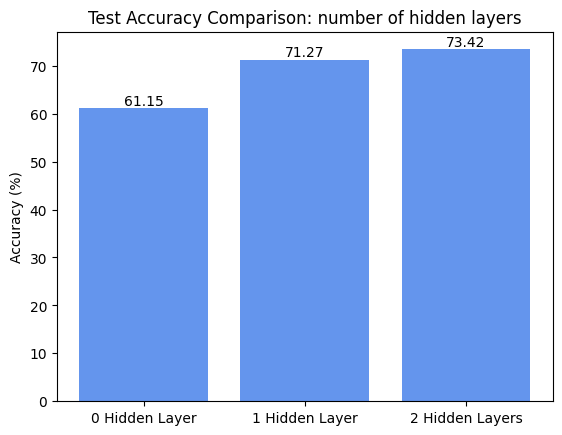

In [ ]:
# plot comparison of test accuracies
plt.figure()
bars = plt.bar(["0 Hidden Layer", "1 Hidden Layer", "2 Hidden Layers"], [test0_acc*100, test1_acc*100, test2_acc*100], color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.title("Test Accuracy Comparison: number of hidden layers")
plt.ylabel("Accuracy (%)")
plt.show()


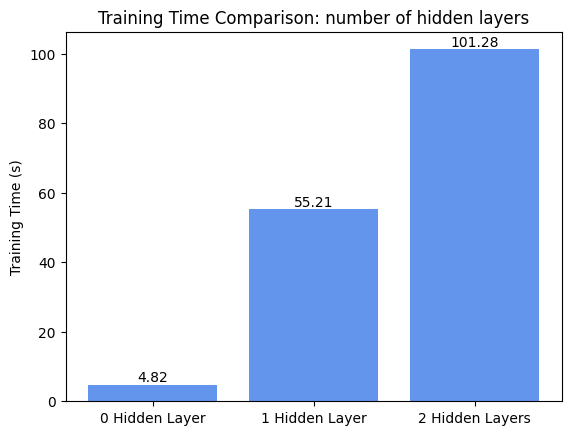

In [ ]:
# plot comparison of test accuracies
plt.figure()
bars = plt.bar(["0 Hidden Layer", "1 Hidden Layer", "2 Hidden Layers"], [MLP_zero_hidden.training_time, MLP_one_hidden.training_time, MLP_two_hidden.training_time], color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.title("Training Time Comparison: number of hidden layers")
plt.ylabel("Training Time (s)")
plt.show()


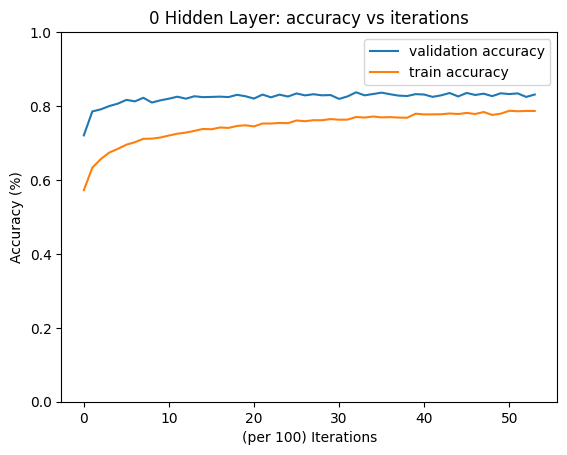

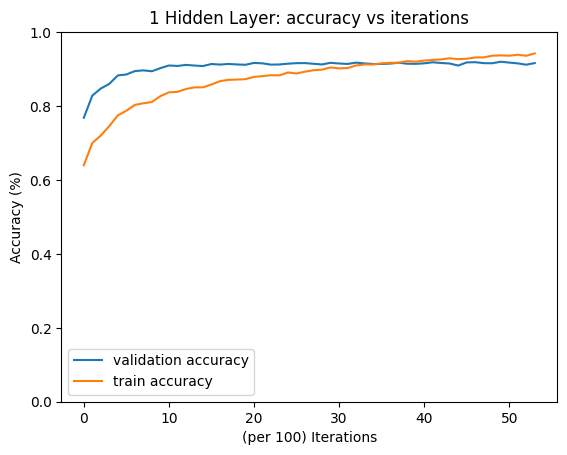

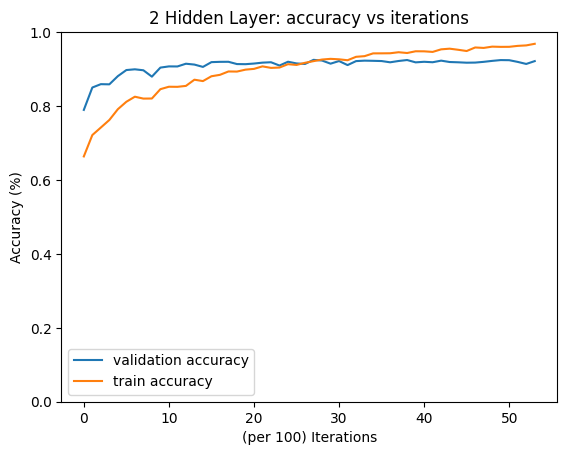

In [ ]:
plot_performance(MLP_zero_hidden)
plot_performance(MLP_one_hidden)
plot_performance(MLP_two_hidden)

* **How non-linearity and network depth affects the accuracy?**

    The introduction of ReLU activations in models with one or more hidden layers greatly enhances the model's ability to capture non-linear patterns in the data. The test accuracy significantly increased when moving from MLP_0_hidden_layer (61.15%) to MLP_1_hidden_layer (71.27%), indicating that non-linearity is crucial for effective learning in neural networks.

    Adding a second hidden layer in MLP_2_hidden_layer further improved the test accuracy (from 71.27% to 73.43%), suggesting that increasing depth allows the model to learn more complex representations. However, there is a trade-off between accuracy and computational cost: deeper networks require more training time (increasing from 55.21 to 101.28 seconds).

* **Are the results expected?**

    The results are consistent with the expectations. Increasing the number of hidden layers (from 0 to 2) improves the model's performance, but also increases the training time. As shown in the plot above, the MLP_0_hidden_layer model is too simple and it is slightly underfitting, as evidenced by its low training accuracy. Unexpectedly, its validation accuracy is higher than its training accuracy, which could be due to the validation set being easier than the training set.


* choosing lr for MLP with two hidden layers

In [ ]:
# Two hidden layers
MLP_two_hidden_lr1 = MLP(
    lr=1e-1,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    record=True
)

MLP_two_hidden_lr2 = MLP(
    lr=1e-3,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    record=True
)

In [ ]:
batch_size = 32
MLP_two_hidden_lr1.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden_lr1.predict(train_x)
train_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

test2_lr1_preds = MLP_two_hidden_lr1.predict(test_x)
test2_lr1_acc = evaluate_acc(test_y, test2_lr1_preds)
print(f"Test Accuracy for MLP with two hidden layers: {test2_lr1_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_lr1.training_time:.2f} seconds")

Training Accuracy: 99.89%
Test Accuracy for MLP with two hidden layers: 76.74%
Training Time: 98.39 seconds


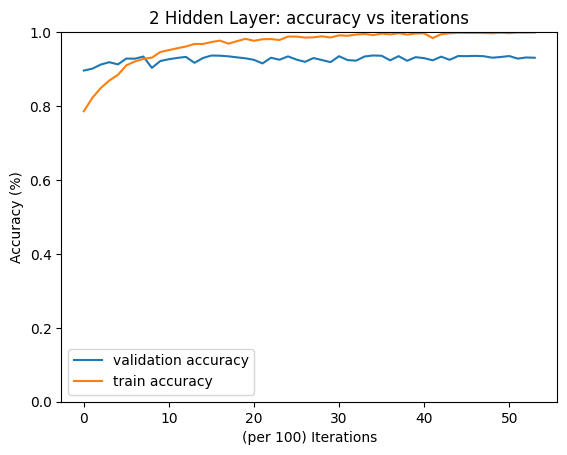

In [ ]:
plot_performance(MLP_two_hidden_lr1)

In [ ]:
MLP_two_hidden_lr2.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden_lr2.predict(train_x)
train_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

test2_lr2_preds = MLP_two_hidden_lr2.predict(test_x)
test2_lr2_acc = evaluate_acc(test_y, test2_lr2_preds)
print(f"Test Accuracy for MLP with two hidden layers: {test2_lr2_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_lr2.training_time:.2f} seconds")

Training Accuracy: 81.35%
Test Accuracy for MLP with two hidden layers: 68.08%
Training Time: 87.93 seconds


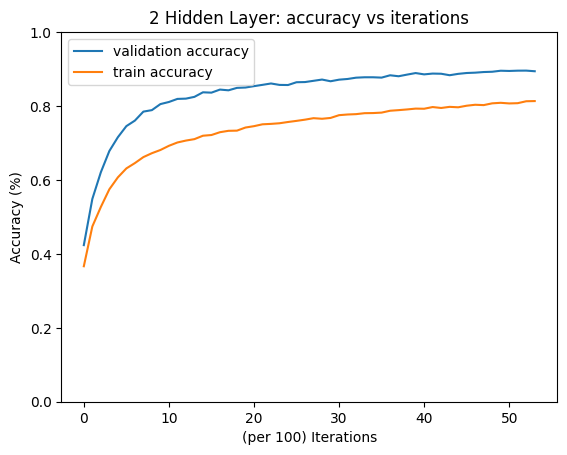

In [ ]:
plot_performance(MLP_two_hidden_lr2)

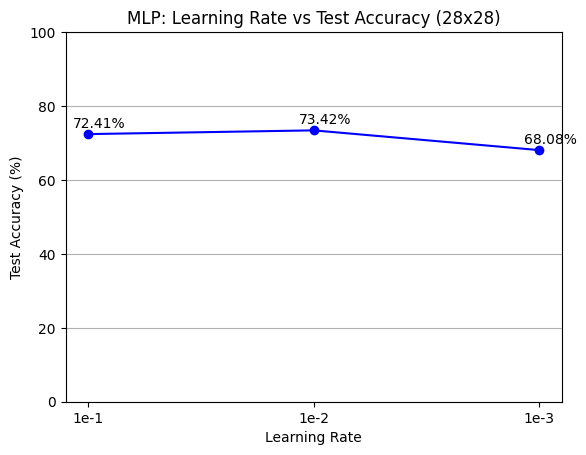

In [ ]:
learning_rates = ["1e-1","1e-2", "1e-3"]
test_accs = [test2_lr1_acc*100, test2_acc*100, test2_lr2_acc*100]
plt.plot(learning_rates, test_accs, marker='o', linestyle='-', color='b')
plt.ylim(0, 100)
plt.xticks(learning_rates)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy (%)')
plt.title('MLP: Learning Rate vs Test Accuracy (28x28)')
for i, (lr, acc) in enumerate(zip(learning_rates, test_accs)):
    plt.text(i+0.05, acc+1, f'{acc:.2f}%', ha='center', va='bottom')
plt.grid(axis='y')
plt.show()

* ### *Task 3.2: compare behaviors of MLP with different activation functions*

In [ ]:
MLP_two_hidden_tanh = MLP(
    lr=1e-2,
    activation_func=tanh,
    activation_func_grad=tanh_grad,
    initializer=he_init,
    L=2,
    M=256,
)

In [ ]:
MLP_two_hidden_leakyRelu = MLP(
    lr=1e-2,
    activation_func=leaky_relu,
    activation_func_grad=leaky_relu_grad,
    initializer=he_init,
    L=2,
    M=256,
)

In [ ]:
MLP_two_hidden_tanh.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden_tanh.predict(train_x)
train2_tanh_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

test2_tanh_preds = MLP_two_hidden_tanh.predict(test_x)
test2_tanh_acc = evaluate_acc(test_y, test2_tanh_preds)
print(f"Test Accuracy: {test2_tanh_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_tanh.training_time:.2f} seconds")

Training Accuracy: 93.41%
Test Accuracy: 71.12%
Training Time: 54.70 seconds


In [ ]:
MLP_two_hidden_leakyRelu.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden_leakyRelu.predict(train_x)
train2_leakyRelu_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

test2_leakyRelu_preds = MLP_two_hidden_leakyRelu.predict(test_x)
test2_leakyRelu_acc = evaluate_acc(test_y, test2_leakyRelu_preds)
print(f"Test Accuracy: {test2_leakyRelu_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_leakyRelu.training_time:.2f} seconds")

Training Accuracy: 96.69%
Test Accuracy: 72.30%
Training Time: 50.19 seconds


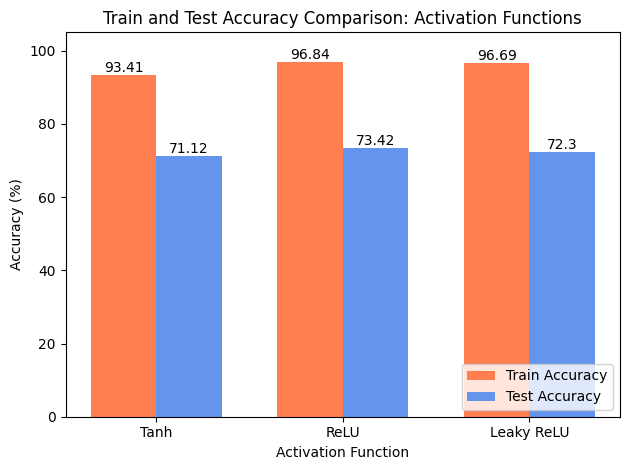

In [ ]:
test_accuracies = [test2_tanh_acc * 100, test2_acc * 100, test2_leakyRelu_acc * 100]
train_accuracies = [train2_tanh_acc * 100, train2_acc * 100, train2_leakyRelu_acc * 100]
labels = ['Tanh', 'ReLU', 'Leaky ReLU']
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='coral')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='cornflowerblue')
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
ax.set_xlabel("Activation Function")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Train and Test Accuracy Comparison: Activation Functions")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc ='lower right')
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()


*  **Comment on the performances of these models**

    With all the other hyperparameters remain unchanged, three models using different activation functions (tanh, ReLU, and Leaky ReLU) were defined. Among the three, the model using ReLU as its activation function performs the best, achieving the highest test accuracy of 73.42%. This indicates that it generalizes the best to unseen data.

    Leaky ReLU achieves a slightly higher training accuracy (96.96%) but a lower test accuracy (72.30%), suggesting that it may have slightly overfit to the training data compared to ReLu. Tanh performs the worst in both training accuracy (93.41%) and test accuracy (71.12%). This is likely due to the squashing effect of the tanh function, which can cause the vanishing gradients problem during backpropagation.

* **If the results are expected?**

    The results align with expectations. While Leaky ReLU addresses the zero-gradient problem seen in ReLU, it may introduce unnecessary noise into the network. With sufficient data, ReLU tends to perform well and generalize effectively on the unseen data.


* ### *Task 3.3: compare behaviors of MLP with different regularizations*

In [ ]:
MLP_two_hidden_L1 = MLP(
    lr=1e-2,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    lambda_L1=5e-4,
    record=True
    )
batch_size = 32

In [ ]:
MLP_two_hidden_L1.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden_L1.predict(train_x)
train_acc_L1 = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc_L1 * 100:.2f}%")

test2_L1_preds = MLP_two_hidden_L1.predict(test_x)
test2_L1_acc = evaluate_acc(test_y, test2_L1_preds)
print(f"Test Accuracy: {test2_L1_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_L1.training_time:.2f} seconds")

Training Accuracy: 93.37%
Test Accuracy: 72.83%
Training Time: 115.06 seconds


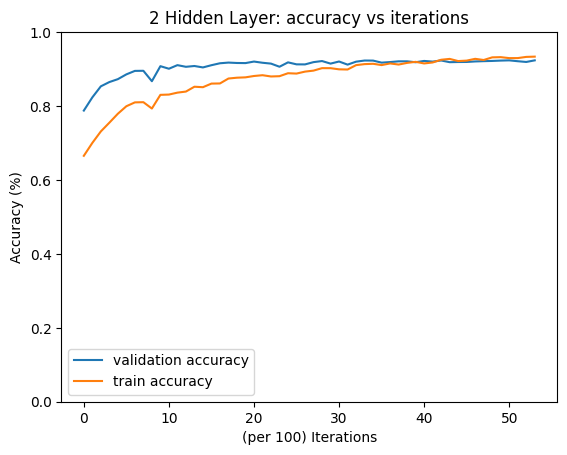

In [ ]:
plot_performance(MLP_two_hidden_L1)

In [ ]:
MLP_two_hidden_L2 = MLP(
    lr=1e-2,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    lambda_L2=5e-3,
    record=True
    )
batch_size = 32

In [ ]:
MLP_two_hidden_L2.fit(train_x, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden_L2.predict(train_x)
train_acc_L2 = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc_L2 * 100:.2f}%")

test2_L2_preds = MLP_two_hidden_L2.predict(test_x)
test2_L2_acc = evaluate_acc(test_y, test2_L2_preds)
print(f"Test Accuracy for MLP with two hidden layers: {test2_L2_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_L2.training_time:.2f} seconds")

Training Accuracy: 93.91%
Test Accuracy for MLP with two hidden layers: 73.15%
Training Time: 98.15 seconds


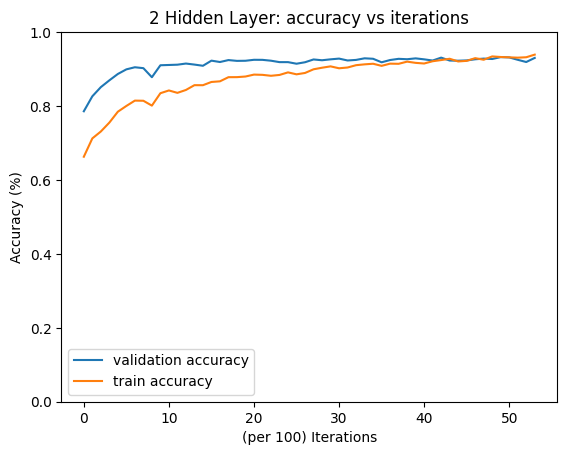

In [ ]:
plot_performance(MLP_two_hidden_L2)

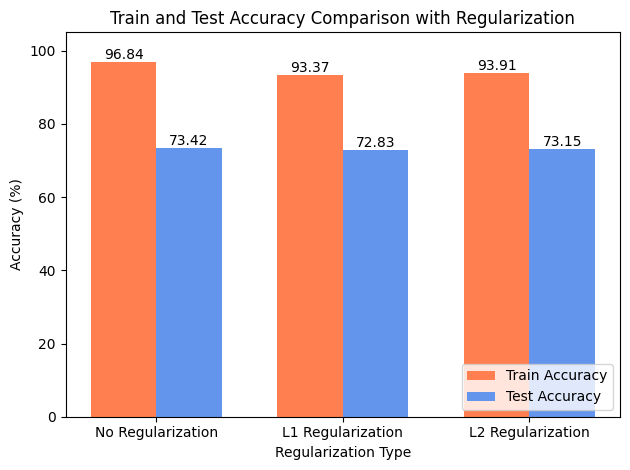

In [ ]:
test_accuracies = [test2_acc * 100, test2_L1_acc * 100, test2_L2_acc * 100]
train_accuracies = [train2_acc * 100, train_acc_L1 * 100, train_acc_L2 * 100]
labels = ["No Regularization", "L1 Regularization", "L2 Regularization"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='coral')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='cornflowerblue')
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
ax.set_xlabel("Regularization Type")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Train and Test Accuracy Comparison with Regularization")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc ='lower right')
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()


* **Regularization Effects**

    From the figure above, the difference between the validation accuracy and training accuracy is smaller for the models with L1 and L2 regularization compared to the model without regularization.

    With L1 regularization, the training accuracy drops from 96.84% to 93.37%. This technique encourages sparsity in the model’s weights, allowing it to focus on the most important features. However, the test accuracy decreases only slightly, from 73.42% to 72.83%. This small drop may be due to the model removing more features than expected.

    With L2 regularization, the training accuracy drops from 96.84% to 93.91%. L2 regularization shrinks the weights, resulting in a smoother decision boundary and better generalization. The drop in test accuracy is very small, indicating that L2 regularization effectively prevents overfitting while maintaining nearly the same generalization performance.

    Therefore, L2 regularization seems to be the best choice, as it achieves almost the same test accuracy as the no-regularization model while slightly reducing overfitting.

    However, the difference between the training accuracy and test accuracy remains relatively high, even with regularization. This suggests that the model is still slightly overfitting to the training data. The learning rate, which was carefully selected to give the best performance before adding regularization, might not be optimal for the current regularization strength. The learning rate may be too high, leading to unstable training and failing to improve generalization to unseen data. Additionally, the regularization strength may not be strong enough in this case.

* ### *Task 3.4: train MLP with unnormalized data*

In [ ]:
MLP_two_hidden_unnormalized = MLP(
    lr=1e-4,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    record=True
)
batch_size = 32

In [ ]:
MLP_two_hidden_unnormalized.fit(train_x_unnormalized, train_y, batch_size=batch_size, max_iter=5e3)
train_preds = MLP_two_hidden_unnormalized.predict(train_x_unnormalized)
train_acc = evaluate_acc(train_y, train_preds)
y2_unnorm_preds = MLP_two_hidden_unnormalized.predict(test_x_unnormalized)
test2_unorm_acc = evaluate_acc(test_y, y2_unnorm_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test2_unorm_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_unnormalized.training_time:.2f} seconds")

Training Accuracy: 76.16%
Test Accuracy: 57.29%
Training Time: 93.36 seconds


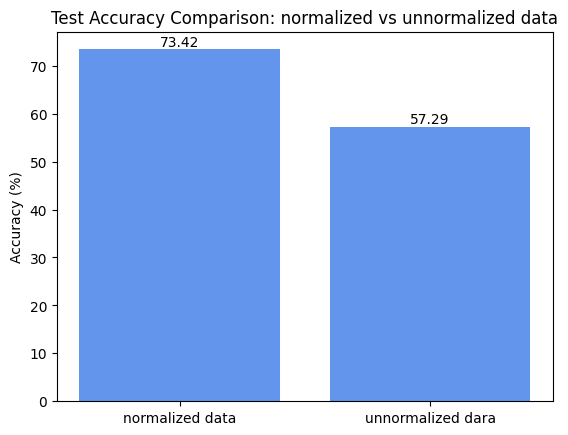

In [ ]:
# plot comparison of test accuracies
plt.figure()
bars = plt.bar(["normalized data", "unnormalized dara"], [test2_acc*100, test2_unorm_acc*100], color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.title("Test Accuracy Comparison: normalized vs unnormalized data")
plt.ylabel("Accuracy (%)")
plt.show()


* **How does training with unormalized model affect the accuracy?**

    With all the hyperparameters remain unchanged, when the images are unnormalized, the model shows a significant drop in both training accuracy (76.16%) and test accuracy (57.29%).

    The dartaset's standard deviation is 75.84, indicating a relatively wide-spreaded pixel intensity. Without normalization, larger intensity values could dominate gradients, leading to slower and unstable training. Some input features, due to their larger numerical values, can dominate the learning process. As a result, with unnormalized images, the model struggles to learn efficiently.

* ### *Task 3.5: compare behaviors of MLP trained with 128 pixels version of OrganAMNIST*

In [ ]:
MLP_two_hidden_L1_2 = MLP(
    lr=1e-2,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    lambda_L1=4e-4
)

MLP_two_hidden_L2_2 = MLP(
    lr=1e-2,
    activation_func=relu,
    activation_func_grad=relu_grad,
    initializer=he_init,
    L=2,
    M=256,
    lambda_L2=5e-3
)

In [ ]:
batch_size = 32
MLP_two_hidden_L1_2.fit(train_x_128, train_y, batch_size=batch_size, max_iter=2e3, is_128x128=True)
train_preds = MLP_two_hidden_L1_2.predict(train_x_128)
train_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

y2_128L1_preds = MLP_two_hidden_L1_2.predict(test_x_128)
test2_128L1_acc = evaluate_acc(test_y, y2_128L1_preds)
print(f"Test Accuracy for MLP with two hidden layers: {test2_128L1_acc * 100:.2f}%")
print(f"Training Time: {MLP_two_hidden_L1_2.training_time:.2f} seconds")

Training Accuracy: 96.42%
Test Accuracy for MLP with two hidden layers: 73.77%
Training Time: 289.70 seconds


In [ ]:
MLP_two_hidden_L2_2.fit(train_x_128, train_y, batch_size=batch_size, max_iter=2e3, is_128x128=True)
train_preds = MLP_two_hidden_L2_2.predict(train_x_128)
train_acc = evaluate_acc(train_y, train_preds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

y2_128L2_preds = MLP_two_hidden_L2_2.predict(test_x_128)
test2_128L2_acc = evaluate_acc(test_y, y2_128L2_preds)
print(f"Test Accuracy for MLP with two hidden layers: {test2_128L2_acc * 100:.2f}%")
print(f"Training time: {MLP_two_hidden_L2_2.training_time:.2f} seconds")

Training Accuracy: 98.47%
Test Accuracy for MLP with two hidden layers: 74.81%
Training time: 165.63 seconds


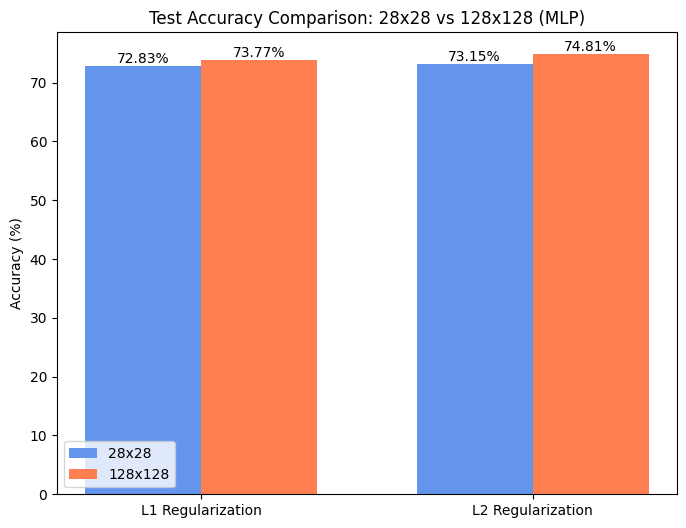

In [ ]:
labels = ['L1 Regularization', 'L2 Regularization']
acc_28x28 = [test2_L1_acc*100, test2_L2_acc*100]
acc_128x128 = [test2_128L1_acc*100, test2_128L2_acc*100]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
bars_28x28 = ax.bar(x - width/2, acc_28x28, width, label='28x28', color='cornflowerblue')
bars_128x128 = ax.bar(x + width/2, acc_128x128, width, label='128x128', color='coral')
for bar in bars_28x28:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
for bar in bars_128x128:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Test Accuracy Comparison: 28x28 vs 128x128 (MLP)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

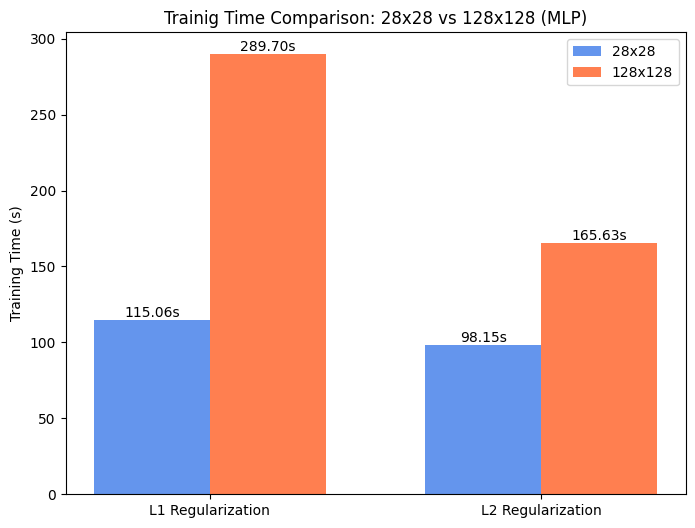

In [ ]:
labels = ['L1 Regularization', 'L2 Regularization']
time_28x28 = [MLP_two_hidden_L1.training_time, MLP_two_hidden_L2.training_time]
time_128x128 = [MLP_two_hidden_L1_2.training_time, MLP_two_hidden_L2_2.training_time]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
bars_28x28 = ax.bar(x - width/2, time_28x28, width, label='28x28', color='cornflowerblue')
bars_128x128 = ax.bar(x + width/2, time_128x128, width, label='128x128', color='coral')
for bar in bars_28x28:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}s', ha='center', va='bottom')
for bar in bars_128x128:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}s', ha='center', va='bottom')
ax.set_ylabel('Training Time (s)')
ax.set_title('Trainig Time Comparison: 28x28 vs 128x128 (MLP)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

* **How the increased input size affect the accuracy?**

    The training accuracy is higher for the 128x128 version (after applying L1 and L2 regularization), indicating that the model is better able to fit the training data. However, this also increases the risk of overfitting. The 128x128 version achieves slightly higher test accuracy (from 72.83% to 73.77 with L1 and from73.15% to 74.81% with L2). This improvement is likely due to the increased spatial resolution, which provides the model with more detailed information for learning patterns. However, some of this detailed information may be redundant. The model learns these unnecessary details, which increases training accuracy but does not significantly enhance test accuracy. While L1 and L2 regularization help to slightly reduce overfitting for 28x28 version by penalizing large weights, they might not fully mitigate the effect of the significantly increased input size.

* **Is the model slower to train (in terms of epochs and compute time) ?**
    The training time for the 128x128 version (289.7 seconds with L1 and 165.63 seconds with L2) is significantly longer compared to the 28x28 version (115.06 seconds with L1 and 98.15 seconds with L2). Both versions required 5000 epochs to train. This extended training time may be due to an overly strict early termination policy (e.g., stopping only when loss has been less than 1e-8 for more than 100 epochs). Neither version satisfied the early stopping condition, so both were trained until the maximum allowed iterations were reached.

For this task, the 28x28 version is more efficient when using MLPs. It achieves nearly the same accuracy as the 128x128 version but with much shorter training times and a lower risk of overfitting.

* ### *Task 3.6: compare MLP and CNN behaviors*

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(dataset, img_dim=28):
    images = dataset.imgs.astype(np.float32)
    labels = dataset.labels.astype(np.int64).flatten()
    # Resize images if needed
    if img_dim == 128:
        images_resized = np.array([np.resize(img, (img_dim, img_dim)) for img in images])
    else:
        images_resized = images

    # Normalize images
    mean = np.mean(images_resized)
    std = np.std(images_resized)
    images_normalized = (images_resized - mean) / std

    # Add channel dimension
    images_normalized = images_normalized[:, None, :, :]  # Shape: (num_samples, channels, height, width)

    # Convert to torch tensors
    images_tensor = torch.tensor(images_normalized, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return TensorDataset(images_tensor, labels_tensor)

# Load and preprocess train and test datasets
train_dataset_CNN = OrganAMNIST(split="train")
test_dataset_CNN = OrganAMNIST(split="test")
val_dataset_CNN = OrganAMNIST(split="val")
train_data_CNN = preprocess_data(train_dataset_CNN, img_dim=28)
test_data_CNN = preprocess_data(test_dataset_CNN, img_dim=28)
val_data_CNN = preprocess_data(val_dataset_CNN, img_dim=28)

train_data_CNN128 = preprocess_data(train_dataset_CNN, img_dim=128)
test_data_CNN128 = preprocess_data(test_dataset_CNN, img_dim=128)
val_data_CNN128 = preprocess_data(val_dataset_CNN, img_dim=128)

# DataLoader for batching
batch_size_CNN = 64
train_loader_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=True)
val_loader_CNN = DataLoader(val_data_CNN, batch_size=batch_size_CNN, shuffle=True)
test_loader_CNN = DataLoader(test_data_CNN, batch_size=batch_size_CNN, shuffle=False)

train_loader_CNN128 = DataLoader(train_data_CNN128, batch_size=batch_size_CNN, shuffle=True)
val_loader_CNN128 = DataLoader(val_data_CNN128, batch_size=batch_size_CNN, shuffle=True)
test_loader_CNN128 = DataLoader(test_data_CNN128, batch_size=batch_size_CNN, shuffle=False)

In [ ]:
"-----------------------------------------------------------------CNN--------------------------------------------------------------------"
class CNN(nn.Module):
    def __init__(self, lr, channels, pixel, kernel_size, stride, padding, record, max_pool_size=2):
        super().__init__()
        self.lr = lr
        self.channels = channels # RGB
        self.pixel = pixel # 28x28 or 128x128
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.max_pool_size = max_pool_size
        self.record = record
        self.train_performance = []
        self.test_performance = []

        layer1_num_filters = 32
        layer2_num_filters = 64
        num_neurons = 256 # number of neurons in the fully connected layer

        C = 11 # number of classes

        # Convolutional layer1
        self.conv1 = nn.Conv2d(in_channels=self.channels, out_channels=layer1_num_filters, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding) # kernel size is filter size
        # Convolutional layer2
        self.conv2 = nn.Conv2d(in_channels=layer1_num_filters, out_channels=layer2_num_filters, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.pool = nn.MaxPool2d(kernel_size=max_pool_size)

        conv_output_size = self.calculate_conv_output_size(pixel)

        # Fully connected layer
        self.fc_hidden = nn.Linear(layer2_num_filters * conv_output_size * conv_output_size, num_neurons)
        self.fc_output = nn.Linear(num_neurons, C)

    def fit(self, train_loader, max_iter, tolerance=1e-6):
        ce = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=self.lr)

        min_loss = np.inf

        self.training_time_CNN = 0
        start_time = time.time()
        for iter in range(max_iter):
            self.train()
            all_train_labels = []
            all_train_preds = []
            for batch_idx, (inputs, true_label) in enumerate(train_loader):
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                pred_label = self(inputs)
                loss = ce(pred_label, true_label)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                all_train_labels.extend(true_label.cpu().numpy())
                all_train_preds.extend(pred_label.argmax(dim=1).cpu().numpy())
                # if (batch_idx+1) % 100 == 0:
                #     print(f'Epoch [{iter}/{max_iter}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

                # loss-based early termination
                if loss.item() < min_loss or loss.item() > tolerance:
                    min_loss = loss.item()
                    patient = 0
                    torch.save(self.state_dict(), 'best_model.pth') # Save the best model

            if self.record:
                train_acc = evaluate_CNN_acc(np.array(all_train_labels), np.array(all_train_preds))
            self.train_performance.append(train_acc)
            if self.pixel == 128:
                test_acc = self.evaluate_accuracy(val_loader_CNN128)
            else:
                test_acc = self.evaluate_accuracy(val_loader_CNN)
            self.test_performance.append(test_acc)

            print(f'Epoch [{iter+1}/{max_iter}], Loss: {loss.item():.4f}')
        end_time = time.time()
        self.training_time_CNN = end_time - start_time

    def calculate_conv_output_size(self, input_size):
        # first convolution layer
        conv1_output = (input_size - self.kernel_size + 2 * self.padding) // self.stride + 1
        pool1_output = conv1_output // self.max_pool_size

        # second convolution layer
        conv2_output = (pool1_output - self.kernel_size + 2 * self.padding) // self.stride + 1
        pool2_output = conv2_output // self.max_pool_size

        return pool2_output

    def forward(self, x):
        # apply first convolution
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        # apply second convolution
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        # flatten
        x = x.view(x.size(0), -1)

        # apply fully connected layers
        x = self.fc_hidden(x)
        x = nn.ReLU()(x)
        x = self.fc_output(x)
        return x

    def predict(self, test_loader):
        self.eval()
        all_preds = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self(inputs)
                output_scores, preds = torch.max(outputs, 1)
                all_preds.append(preds)

        return torch.cat(all_preds)

    def evaluate_accuracy(self, loader):
        self.eval()
        all_test_labels = []
        all_test_preds = []

        with torch.no_grad():
            for inputs, labels in loader:
                outputs = self(inputs)
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(outputs.argmax(dim=1).cpu().numpy())

        return evaluate_CNN_acc(np.array(all_test_labels), np.array(all_test_preds))

def evaluate_CNN_acc(true_labels, predictions):
    # Ensure predictions is a NumPy array
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()

    if predictions.ndim == 2:
        predictions = predictions.flatten()

    correct = np.sum(true_labels == predictions)
    total = len(true_labels)
    return correct / total

def CNN_plot_performance(model, max_iter):
    plt.figure()
    plt.plot(model.test_performance, label="validation accuracy")
    plt.plot(model.train_performance, label="train accuracy")
    plt.title('Accuracy vs Iterations')
    plt.xlabel("Iterations")
    plt.xticks(np.arange(0, max_iter, step=1))
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
CNN_28x28_k5 = CNN(
    lr=1e-4,
    channels=1,
    pixel=28,
    kernel_size=5,
    stride=1,
    padding=1,
    record=True
)

CNN_28x28_k5_lr1 = CNN(
    lr=1e-3,
    channels=1,
    pixel=28,
    kernel_size=5,
    stride=1,
    padding=1,
    record=True

)

CNN_28x28_k5_lr2 = CNN(
    lr=9e-4,
    channels=1,
    pixel=28,
    kernel_size=5,
    stride=1,
    padding=1,
    record=True
)

In [ ]:
CNN_28x28_k5.fit(train_loader_CNN, max_iter=8)

Epoch [1/8], Loss: 0.7394
Epoch [2/8], Loss: 0.3084
Epoch [3/8], Loss: 0.1805
Epoch [4/8], Loss: 0.0002
Epoch [5/8], Loss: 0.0004
Epoch [6/8], Loss: 0.0002
Epoch [7/8], Loss: 0.0000
Epoch [8/8], Loss: 0.0586


In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k5.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN_k5 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN_k5 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k5 = CNN_28x28_k5.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k5 = evaluate_CNN_acc(test_labels, test_preds_CNN_k5.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k5 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k5.training_time_CNN / 60)}m {CNN_28x28_k5.training_time_CNN % 60:.1f}s")

Training Accuracy: 94.99%
Test Accuracy: 83.03%
Training Time: 2m 23.4s


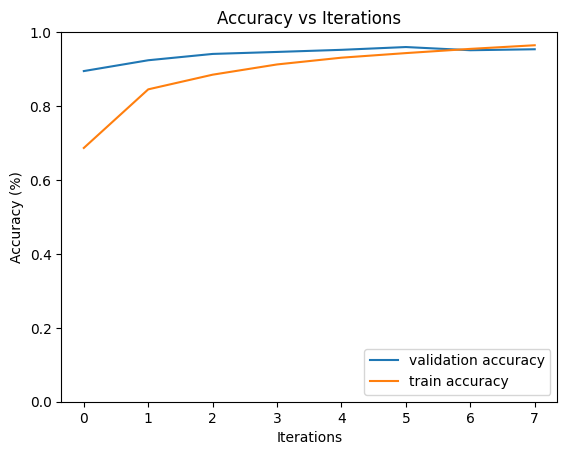

In [ ]:
CNN_plot_performance(CNN_28x28_k5, 8)

In [ ]:
CNN_28x28_k5_lr1.fit(train_loader_CNN, max_iter=8)

Epoch [1/8], Loss: 0.9040
Epoch [2/8], Loss: 0.1381
Epoch [3/8], Loss: 0.0000
Epoch [4/8], Loss: 0.0000
Epoch [5/8], Loss: 0.0000
Epoch [6/8], Loss: 0.0000
Epoch [7/8], Loss: 0.0000
Epoch [8/8], Loss: 0.0000


In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k5_lr1.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN1 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN1 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k5lr1 = CNN_28x28_k5_lr1.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k5lr1 = evaluate_CNN_acc(test_labels, test_preds_CNN_k5lr1.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k5lr1 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k5_lr1.training_time_CNN / 60)}m {CNN_28x28_k5_lr1.training_time_CNN % 60:.1f}s")

Training Accuracy: 98.36%
Test Accuracy: 84.43%
Training Time: 4m 1.6s


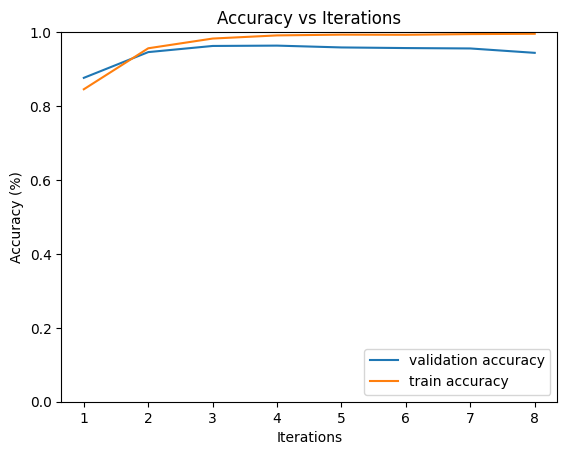

In [ ]:
CNN_plot_performance(CNN_28x28_k5_lr1, 8)

In [ ]:
CNN_28x28_k5_lr2.fit(train_loader_CNN, max_iter=4)

Epoch [1/4], Loss: 0.0000
Epoch [2/4], Loss: 0.0000
Epoch [3/4], Loss: 0.4708
Epoch [4/4], Loss: 0.0000


In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k5_lr2.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN2 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN2 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k5lr2 = CNN_28x28_k5_lr2.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k5lr2 = evaluate_CNN_acc(test_labels, test_preds_CNN_k5lr2.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k5lr2 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k5_lr2.training_time_CNN / 60)}m {CNN_28x28_k5_lr2.training_time_CNN % 60:.1f}s")

Training Accuracy: 99.39%
Test Accuracy: 88.00%
Training Time: 2m 3.0s


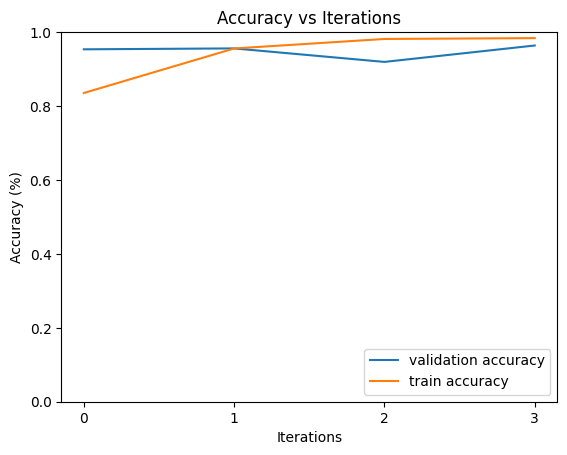

In [ ]:
CNN_plot_performance(CNN_28x28_k5_lr2,4)

kernel size = 5

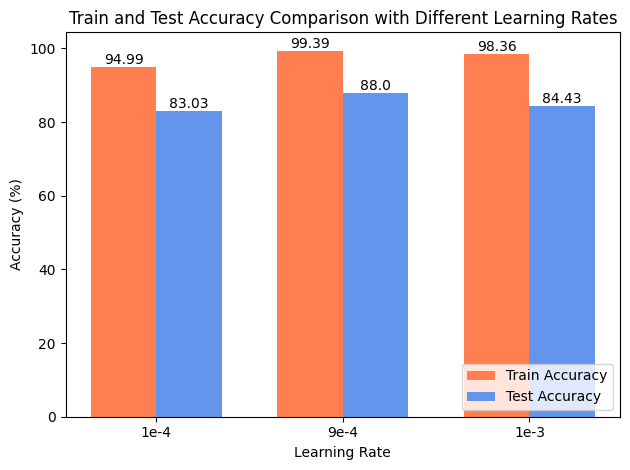

In [ ]:
test_accuracies = [test_acc_CNN_k5 * 100, test_acc_CNN_k5lr2 * 100, test_acc_CNN_k5lr1 * 100]
train_accuracies = [train_acc_CNN_k5 * 100, train_acc_CNN2 * 100, train_acc_CNN1 * 100]

labels = ["1e-4", "9e-4", "1e-3"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='coral')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='cornflowerblue')
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Train and Test Accuracy Comparison with Different Learning Rates")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc ='lower right')
ax.set_ylim()
plt.tight_layout()
plt.show()


In [ ]:
CNN_28x28_k3 = CNN(
    lr=1e-4,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=1,
    padding=1,
    record=True

)

CNN_28x28_k3_lr1 = CNN(
    lr=9e-4,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=1,
    padding=1,
    record=True
)


In [ ]:
CNN_28x28_k3_lr2 = CNN(
    lr=5e-3,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=1,
    padding=1,
    record=True

)

In [ ]:
CNN_28x28_k3.fit(train_loader_CNN, max_iter=8)

Epoch [1/8], Loss: 0.0035
Epoch [2/8], Loss: 0.6705
Epoch [3/8], Loss: 0.0001
Epoch [4/8], Loss: 0.2793
Epoch [5/8], Loss: 0.7794
Epoch [6/8], Loss: 0.0000
Epoch [7/8], Loss: 0.0000
Epoch [8/8], Loss: 0.0324


In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3 = CNN_28x28_k3.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3.training_time_CNN / 60)}m {CNN_28x28_k3.training_time_CNN % 60:.1f}s")

Training Accuracy: 97.49%
Test Accuracy: 85.63%
Training Time: 4m 4.7s


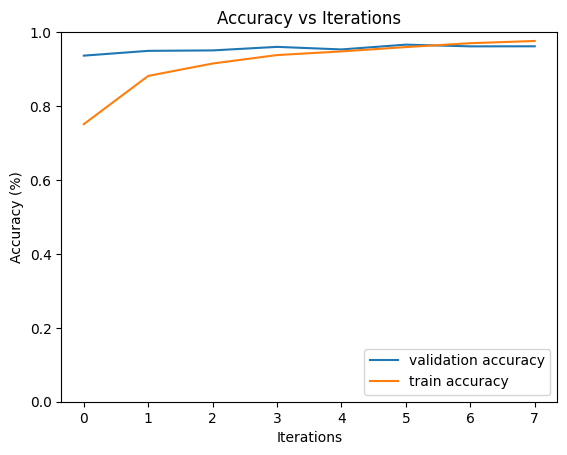

In [ ]:
CNN_plot_performance(CNN_28x28_k3,8)

In [ ]:
CNN_28x28_k3_lr1.fit(train_loader_CNN, max_iter=4)

Epoch [1/4], Loss: 0.0441
Epoch [2/4], Loss: 0.0000
Epoch [3/4], Loss: 0.0214
Epoch [4/4], Loss: 0.0010


In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3_lr1.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNNk3_1 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNNk3_1 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3lr1 = CNN_28x28_k3_lr1.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3lr1 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3lr1.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3lr1 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3_lr1.training_time_CNN / 60)}m {CNN_28x28_k3_lr1.training_time_CNN % 60:.1f}s")

Training Accuracy: 99.23%
Test Accuracy: 86.79%
Training Time: 2m 0.9s


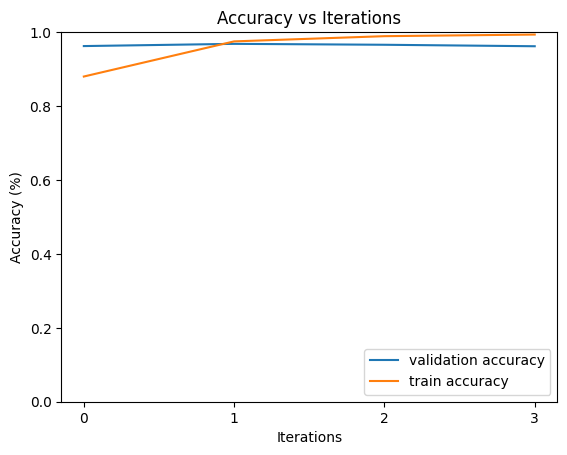

In [ ]:
CNN_plot_performance(CNN_28x28_k3_lr1,4)

In [ ]:
CNN_28x28_k3_lr2.fit(train_loader_CNN, max_iter=4)

Epoch [1/4], Loss: 0.0024
Epoch [2/4], Loss: 0.0000
Epoch [3/4], Loss: 0.0015
Epoch [4/4], Loss: 0.0000


In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3_lr2.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNNk3_2 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNNk3_2 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3lr2 = CNN_28x28_k3_lr2.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3lr2 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3lr2.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3lr2 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3_lr2.training_time_CNN / 60)}m {CNN_28x28_k3_lr2.training_time_CNN % 60:.1f}s")

Training Accuracy: 98.19%
Test Accuracy: 84.85%
Training Time: 1m 54.9s


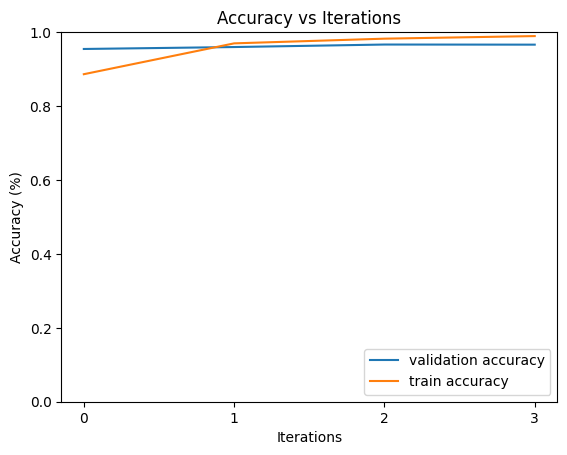

In [ ]:
CNN_plot_performance(CNN_28x28_k3_lr2,4)

* kernel size = 3

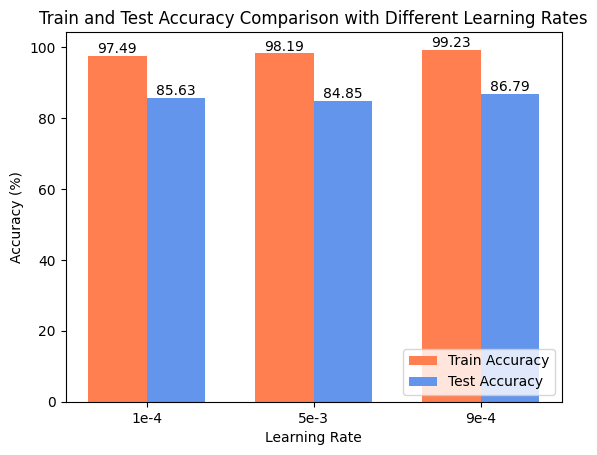

In [ ]:
# bar plot comparison of test accuracies and train accuracies with differenct learning rate
test_accuracies = [test_acc_CNN_k3 * 100, test_acc_CNN_k3lr2 * 100, test_acc_CNN_k3lr1 * 100]
train_accuracies = [train_acc_CNN * 100, train_acc_CNNk3_2 * 100, train_acc_CNNk3_1 * 100]
labels = ["1e-4", "5e-3", "9e-4"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='coral')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='cornflowerblue')
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Train and Test Accuracy Comparison with Different Learning Rates")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc ='lower right')
plt.show()

In [ ]:
CNN_128x128_k5 = CNN(
    lr=3e-4,
    channels=1,
    pixel=128,
    kernel_size=5,
    stride=2,
    padding=1,
    record=True
)

In [ ]:
CNN_128x128_k5.fit(train_loader_CNN128, max_iter=8)

Epoch [1/8], Loss: 0.0522
Epoch [2/8], Loss: 1.0893
Epoch [3/8], Loss: 0.0000
Epoch [4/8], Loss: 0.0000
Epoch [5/8], Loss: 0.0025
Epoch [6/8], Loss: 0.0020
Epoch [7/8], Loss: 0.0000
Epoch [8/8], Loss: 0.0000


In [ ]:
train_loader2_CNN128 = DataLoader(train_data_CNN128, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_128x128_k5.predict(train_loader2_CNN128)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN128]).cpu().numpy()
train_acc_CNNk5_128 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNNk5_128 * 100:.2f}%")

# Test accuracy
test_preds_CNN_128k5 = CNN_128x128_k5.predict(test_loader_CNN128)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN128]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_128k5 = evaluate_CNN_acc(test_labels, test_preds_CNN_128k5.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_128k5 * 100:.2f}%")
print(f"Training Time: {int(CNN_128x128_k5.training_time_CNN / 60)}m {CNN_128x128_k5.training_time_CNN % 60:.1f}s")

Training Accuracy: 99.45%
Test Accuracy: 81.53%
Training Time: 10m 1.9s


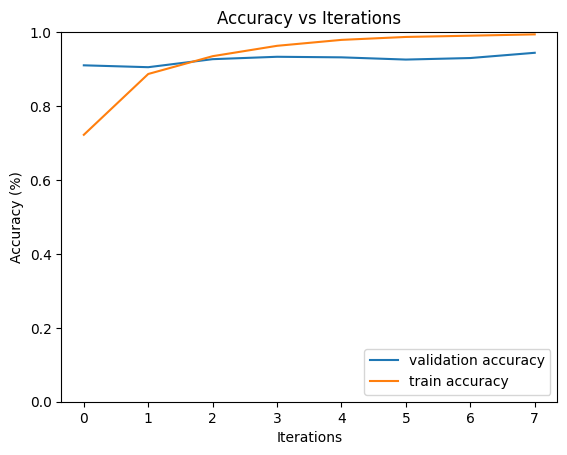

In [ ]:
CNN_plot_performance(CNN_128x128_k5, 8)

In [ ]:
CNN_128x128_k3 = CNN(
    lr=3e-4,
    channels=1,
    pixel=128,
    kernel_size=3,
    stride=2,
    padding=1,
    record=True
)

In [ ]:
CNN_128x128_k3.fit(train_loader_CNN128, max_iter=7)

Epoch [1/7], Loss: 0.0020
Epoch [2/7], Loss: 0.0100
Epoch [3/7], Loss: 0.1496
Epoch [4/7], Loss: 0.0176
Epoch [5/7], Loss: 0.1448
Epoch [6/7], Loss: 0.0007
Epoch [7/7], Loss: 0.0000


In [ ]:
train_loader2_CNN128 = DataLoader(train_data_CNN128, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_128x128_k3.predict(train_loader2_CNN128)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN128]).cpu().numpy()
train_acc_CNNk3_128 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNNk3_128 * 100:.2f}%")

# Test accuracy
test_preds_CNN_128 = CNN_128x128_k3.predict(test_loader_CNN128)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN128]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_128 = evaluate_CNN_acc(test_labels, test_preds_CNN_128.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_128 * 100:.2f}%")
print(f"Training Time: {int(CNN_128x128_k3.training_time_CNN / 60)}m {CNN_128x128_k3.training_time_CNN % 60:.1f}s")

Training Accuracy: 99.13%
Test Accuracy: 81.72%
Training Time: 7m 16.4s


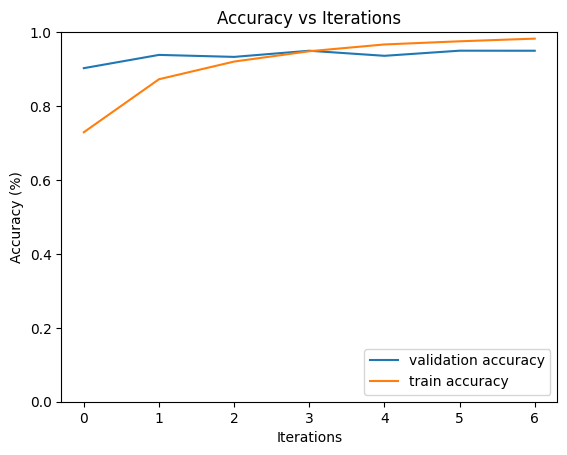

In [ ]:
CNN_plot_performance(CNN_128x128_k3,7)

* CNN 28x28 v.s. CNN 128x128

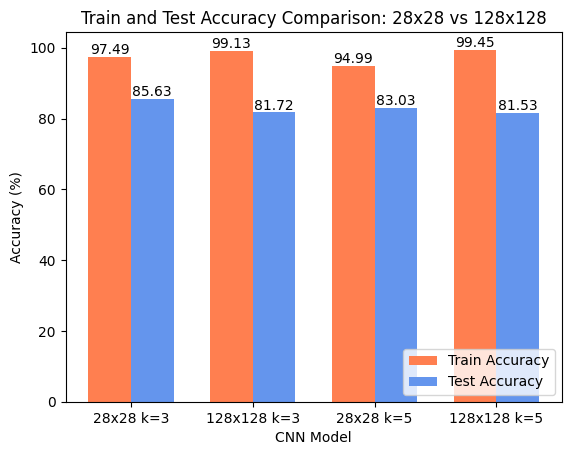

In [ ]:
# bar plot comparison of test accuracies and train accuracies 28x28 vs 128x128
test_accuracies = [test_acc_CNN_k3 * 100, test_acc_CNN_128 * 100, test_acc_CNN_k5 * 100, test_acc_CNN_128k5 * 100]
train_accuracies = [train_acc_CNN * 100, train_acc_CNNk3_128 * 100, train_acc_CNN_k5 * 100, train_acc_CNNk5_128 * 100]
labels = ["28x28 k=3", "128x128 k=3", "28x28 k=5", "128x128 k=5"]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='coral')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='cornflowerblue')
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
ax.set_xlabel("CNN Model")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Train and Test Accuracy Comparison: 28x28 vs 128x128")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc ='lower right')
plt.show()


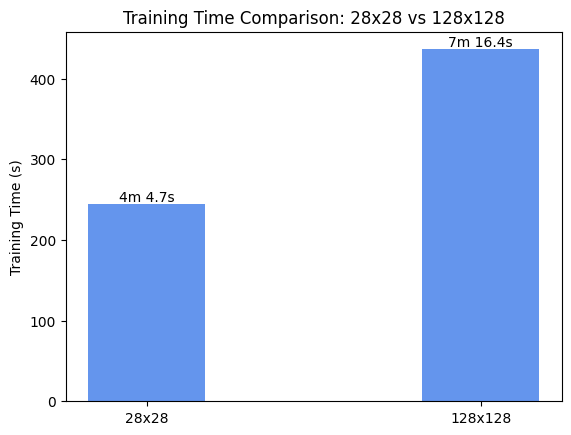

In [ ]:
# bar plot comparison of training time 28x28 vs 128x128
labels = ["28x28", "128x128"]
time = [CNN_28x28_k3.training_time_CNN, CNN_128x128_k3.training_time_CNN]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
bars = ax.bar(x, time, width, color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval/60)}m {yval % 60:.1f}s', ha='center', va='bottom')
ax.set_ylabel('Training Time (s)')
ax.set_title('Training Time Comparison: 28x28 vs 128x128')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

* MLP v.s. CNN (28x28)

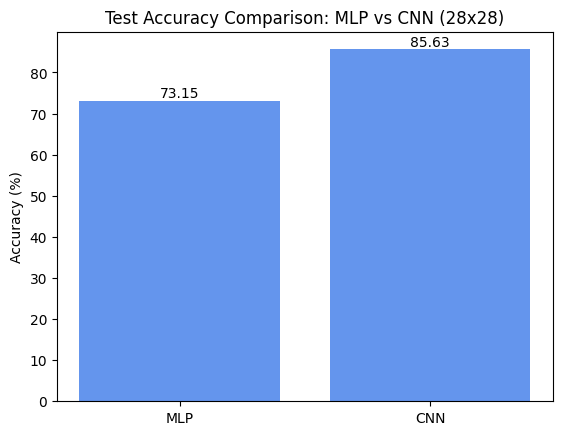

In [ ]:
# plot comparison of test accuracies
plt.figure()
bars = plt.bar(["MLP", "CNN"], [test2_L2_acc*100, test_acc_CNN_k3*100], color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.title("Test Accuracy Comparison: MLP vs CNN (28x28)")
plt.ylabel("Accuracy (%)")
plt.show()


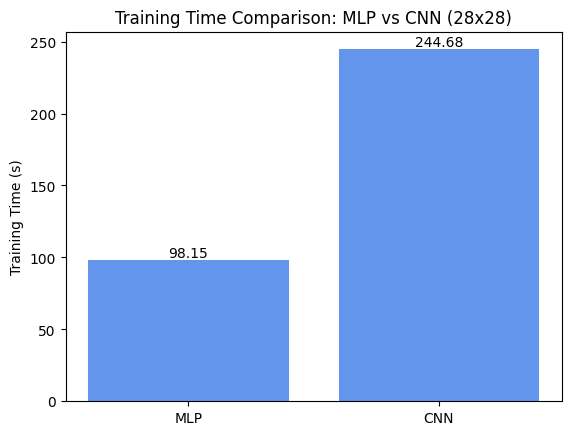

In [ ]:
plt.figure()
bars = plt.bar(["MLP", "CNN"], [MLP_two_hidden_L2.training_time, CNN_28x28_k3.training_time_CNN], color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.title("Training Time Comparison: MLP vs CNN (28x28)")
plt.ylabel("Training Time (s)")
plt.show()

* MLP v.s. CNN (128x128)

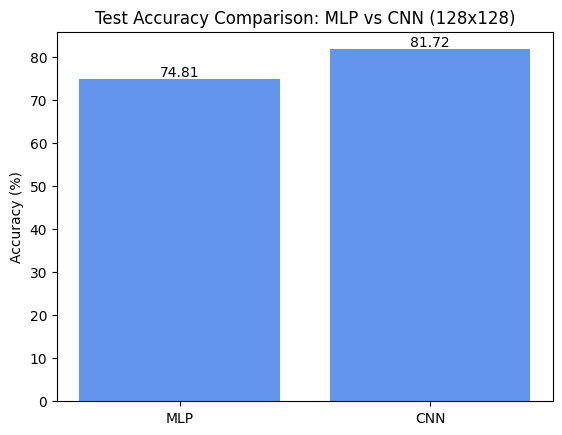

In [ ]:
# plot comparison of test accuracies (128x128)
plt.figure()
bars = plt.bar(["MLP", "CNN"], [test2_128L2_acc*100, test_acc_CNN_128*100], color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.title("Test Accuracy Comparison: MLP vs CNN (128x128)")
plt.ylabel("Accuracy (%)")
plt.show()


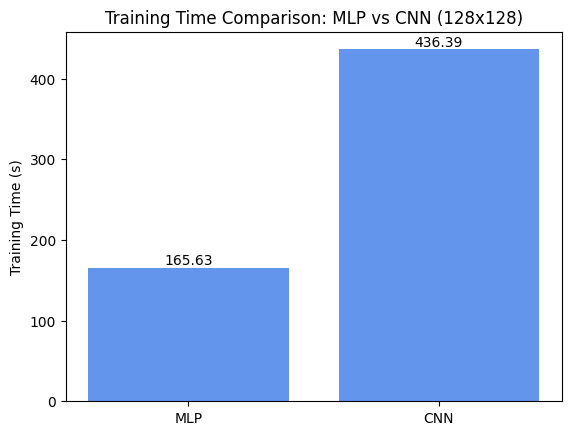

In [ ]:
# plot comparison of training time (128x128)
plt.figure()
bars = plt.bar(["MLP", "CNN"], [MLP_two_hidden_L2_2.training_time, CNN_128x128_k3.training_time_CNN], color='cornflowerblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.title("Training Time Comparison: MLP vs CNN (128x128)")
plt.ylabel("Training Time (s)")
plt.show()


* ### *How padding and stride affect CNN performance*

In [ ]:
CNN_28x28_k3p0 = CNN(
    lr=1e-4,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=1,
    padding=0,
)

CNN_28x28_k3p2 = CNN(
    lr=1e-4,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=1,
    padding=2,
)

CNN_28x28_k3s2p0 = CNN(
    lr=1e-4,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=2,
    padding=0,
)

CNN_28x28_k3s2 = CNN(
    lr=1e-4,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=2,
    padding=1,
)

CNN_28x28_k3s2p2 = CNN(
    lr=1e-4,
    channels=1,
    pixel=28,
    kernel_size=3,
    stride=2,
    padding=2,
)

In [ ]:
CNN_28x28_k3p0.fit(train_loader_CNN, max_iter=8)

In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3p0.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN_k3p0 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN_k3p0 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3p0 = CNN_28x28_k3p0.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3p0 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3p0.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3p0 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3p0.training_time_CNN / 60)}m {CNN_28x28_k3p0.training_time_CNN % 60:.1f}s")

Training Accuracy: 92.43%
Test Accuracy: 79.28%
Training Time: 3m 25.1s


In [ ]:
CNN_28x28_k3p2.fit(train_loader_CNN, max_iter=8)

In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3p2.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN_k3p2 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN_k3p2 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3p2 = CNN_28x28_k3p2.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3p2 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3p2.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3p2 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3p2.training_time_CNN / 60)}m {CNN_28x28_k3p2.training_time_CNN % 60:.1f}s")

Training Accuracy: 98.78%
Test Accuracy: 86.44%
Training Time: 4m 50.0s


In [ ]:
CNN_28x28_k3s2.fit(train_loader_CNN, max_iter=8)

In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3s2.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN_k3s2 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN_k3s2 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3s2 = CNN_28x28_k3s2.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3s2 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3s2.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3s2 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3s2.training_time_CNN / 60)}m {CNN_28x28_k3s2.training_time_CNN % 60:.1f}s")

Training Accuracy: 91.91%
Test Accuracy: 80.70%
Training Time: 1m 25.2s


In [ ]:
CNN_28x28_k3s2p0.fit(train_loader_CNN, max_iter=8)

In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3s2p0.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN_k3s2p0 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN_k3s2p0 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3s2p0 = CNN_28x28_k3s2p0.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3s2p0 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3s2p0.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3s2p0 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3s2p0.training_time_CNN / 60)}m {CNN_28x28_k3s2p0.training_time_CNN % 60:.1f}s")

Training Accuracy: 82.67%
Test Accuracy: 71.57%
Training Time: 1m 34.4s


In [ ]:
CNN_28x28_k3s2p2.fit(train_loader_CNN, max_iter=8)

In [ ]:
train_loader2_CNN = DataLoader(train_data_CNN, batch_size=batch_size_CNN, shuffle=False)
train_preds_CNN = CNN_28x28_k3s2p2.predict(train_loader2_CNN)
train_labels = torch.cat([batch[1] for batch in train_loader2_CNN]).cpu().numpy()
train_acc_CNN_k3s2p2 = evaluate_CNN_acc(train_labels, train_preds_CNN.cpu().numpy())
print(f"Training Accuracy: {train_acc_CNN_k3s2p2 * 100:.2f}%")

# Test accuracy
test_preds_CNN_k3s2p2 = CNN_28x28_k3s2p2.predict(test_loader_CNN)
test_labels = torch.cat([batch[1] for batch in test_loader_CNN]).cpu().numpy()  # concatenate all labels in test_loader
test_acc_CNN_k3s2p2 = evaluate_CNN_acc(test_labels, test_preds_CNN_k3s2p2.cpu().numpy())
print(f"Test Accuracy: {test_acc_CNN_k3s2p2 * 100:.2f}%")
print(f"Training Time: {int(CNN_28x28_k3s2p2.training_time_CNN / 60)}m {CNN_28x28_k3s2p2.training_time_CNN % 60:.1f}s")

Training Accuracy: 90.76%
Test Accuracy: 81.00%
Training Time: 1m 11.1s


In [ ]:
import pandas as pd

columns = [' ', 'CNN:', 'learning rate = 1e-4', 'kernel size = 3', '']
data = [['' for _ in range(5)] for _ in range(7)]
df = pd.DataFrame(data, columns=columns)
# Show the table with the title
header_row = pd.DataFrame([['stride', 'padding', 'test accuracy', 'train accuracy', 'training time']], columns=columns)
df = pd.concat([header_row, df], ignore_index=True)

df.iloc[1, 0] = CNN_28x28_k3p0.stride
df.iloc[1, 1] = CNN_28x28_k3p0.padding
df.iloc[1, 2] = test_acc_CNN_k3p0*100
df.iloc[1, 3] = train_acc_CNN_k3p0*100
df.iloc[1, 4] = f'{CNN_28x28_k3p0.training_time_CNN:.2f}'

df.iloc[2, 0] = CNN_28x28_k3.stride
df.iloc[2, 1] = CNN_28x28_k3.padding
df.iloc[2, 2] = test_acc_CNN_k3*100
df.iloc[2, 3] = train_acc_CNN*100
df.iloc[2, 4] = f'{CNN_28x28_k3.training_time_CNN:.2f}'

df.iloc[3, 0] = CNN_28x28_k3p2.stride
df.iloc[3, 1] = CNN_28x28_k3p2.padding
df.iloc[3, 2] = test_acc_CNN_k3p2*100
df.iloc[3, 3] = train_acc_CNN_k3p2*100
df.iloc[3, 4] = f'{CNN_28x28_k3p2.training_time_CNN:.2f}'

df.iloc[4, 0] = CNN_28x28_k3s2p0.stride
df.iloc[4, 1] = CNN_28x28_k3s2p0.padding
df.iloc[4, 2] = test_acc_CNN_k3s2p0*100
df.iloc[4, 3] = train_acc_CNN_k3s2p0*100
df.iloc[4, 4] = f'{CNN_28x28_k3s2p0.training_time_CNN:.2f}'

df.iloc[5, 0] = CNN_28x28_k3s2.stride
df.iloc[5, 1] = CNN_28x28_k3s2.padding
df.iloc[5, 2] = test_acc_CNN_k3s2*100
df.iloc[5, 3] = train_acc_CNN_k3s2*100
df.iloc[5, 4] = f'{CNN_28x28_k3s2.training_time_CNN:.2f}'

df.iloc[6, 0] = CNN_28x28_k3s2p2.stride
df.iloc[6, 1] = CNN_28x28_k3s2p2.padding
df.iloc[6, 2] = test_acc_CNN_k3s2p2*100
df.iloc[6, 3] = train_acc_CNN_k3s2p2*100
df.iloc[6, 4] = f'{CNN_28x28_k3s2p2.training_time_CNN:.2f}'

df = df.style.set_properties(**{'text-align': 'center'})
df.hide(axis=0)
df


,CNN:,learning rate = 1e-4,kernel size = 3,
stride,padding,test accuracy,train accuracy,training time
1,0,79.277759,92.430775,205.14
1,1,85.628305,97.485605,244.68
1,2,86.438295,98.778971,290.02
2,0,71.571605,82.674112,94.40
2,1,80.700866,91.907063,85.21
2,2,81.004612,90.761263,71.07
,,,,


* ### *Task 3.8: compare behaviors of pre-trained model (LeNet), MLP and CNN*

In [ ]:
class LeNet5Modified(nn.Module):
    def __init__(self, num_classes=11, fc_layers=[84, 64]):
        super(LeNet5Modified, self).__init__()

        # Convolutional layers (keeping them frozen)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, padding=0)

        # Freeze the convolutional layers
        for param in self.conv1.parameters():
            param.requires_grad = False
        for param in self.conv2.parameters():
            param.requires_grad = False
        for param in self.conv3.parameters():
            param.requires_grad = False

        # Define fully connected layers dynamically
        fc_layers = [120 * 3 * 3] + fc_layers + [num_classes]
        self.fc_layers = nn.ModuleList()
        for i in range(len(fc_layers) - 1):
            self.fc_layers.append(nn.Linear(fc_layers[i], fc_layers[i + 1]))

        # Activation function and pooling
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)  # Flatten

        # Forward pass through fully connected layers
        for layer in self.fc_layers[:-1]:  # Apply ReLU to all but the last layer
            x = self.relu(layer(x))
        x = self.fc_layers[-1](x)  # Last layer without activation

        return x


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            if labels.ndim > 1:
                labels = labels.flatten()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Record training accuracy
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Evaluate on test set
        test_accuracy = evaluate_lenet(model, test_loader)
        test_accuracies.append(test_accuracy)

        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    return train_accuracies, test_accuracies

def evaluate_lenet(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            output_scores, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            if labels.ndim > 1:
                labels = labels.flatten()
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
def plot_accuracies(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)  # Epoch numbers

    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')

    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.ylim([0, 100])
    plt.title('Training and Test Accuracies over Iterations')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset_lenet = OrganAMNIST(split='train', transform=transform)
test_dataset_lenet = OrganAMNIST(split='test', transform=transform)
val_dataset_lenet = OrganAMNIST(split='val', transform=transform)

train_loader_lenet = torch.utils.data.DataLoader(train_dataset_lenet, batch_size=32, shuffle=True)
test_loader_lenet = torch.utils.data.DataLoader(test_dataset_lenet, batch_size=32, shuffle=False)
val_loader_lenet = torch.utils.data.DataLoader(val_dataset_lenet, batch_size=32, shuffle=False)

In [ ]:
lenet1_128 = LeNet5Modified(num_classes=11, fc_layers=[128])
criterion1_128 = nn.CrossEntropyLoss()
optimizer1_128 = optim.Adam(lenet1_128.parameters(), lr=5e-3)
start_time_lenet = time.time()
arr_train_acc_lenet1_128, arr_test_acc_lenet1_128 = train_model(lenet1_128, train_loader_lenet, val_loader_lenet, criterion1_128, optimizer1_128, num_epochs=10)
end_time_lenet = time.time()
training_time_lenet1_128 = end_time_lenet - start_time_lenet

In [ ]:
train_acc_lenet1_128 = evaluate_lenet(lenet1_128, train_loader_lenet)
test_acc_lenet1_128 = evaluate_lenet(lenet1_128, test_loader_lenet)
print(f"Training Accuracy: {train_acc_lenet1_128:.2f}%")
print(f"Test Accuracy: {test_acc_lenet1_128:.2f}%")
print(f"Training Time: {int(training_time_lenet1_128 / 60)}m {training_time_lenet1_128 % 60:.1f}s")

Training Accuracy: 96.35%
Test Accuracy: 77.92%
Training Time: 2m 48.7s


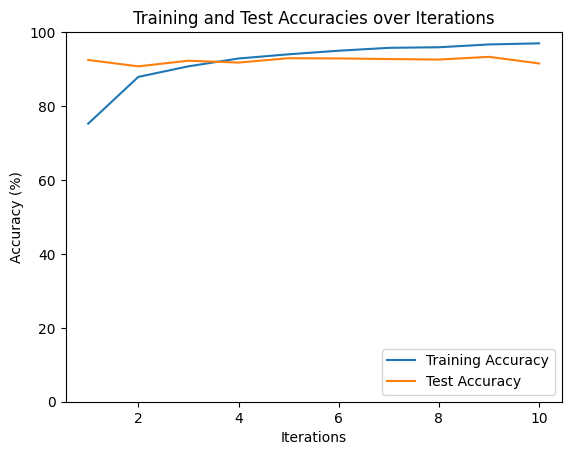

In [ ]:
plot_accuracies(arr_train_acc_lenet1_128, arr_test_acc_lenet1_128)

In [ ]:
lenet = LeNet5Modified(num_classes=11, fc_layers=[256])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet.parameters(), lr= 5e-3)
start_time_lenet = time.time()
arr_train_acc_lenet1, arr_test_acc_lenet1 = train_model(lenet, train_loader_lenet, val_loader_lenet, criterion, optimizer, num_epochs=10)
end_time_lenet = time.time()
training_time_lenet1 = end_time_lenet - start_time_lenet

In [ ]:
train_acc_lenet = evaluate_lenet(lenet, train_loader_lenet)
test_acc_lenet = evaluate_lenet(lenet, test_loader_lenet)
print(f"Training Accuracy: {train_acc_lenet:.2f}%")
print(f"Test Accuracy: {test_acc_lenet:.2f}%")
print(f"Training Time: {int(training_time_lenet1 / 60)}m {training_time_lenet1 % 60:.1f}s")

Training Accuracy: 97.07%
Test Accuracy: 80.12%
Training Time: 3m 42.8s


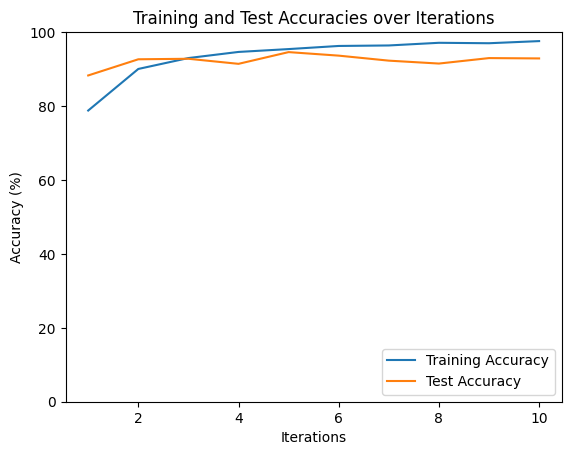

In [ ]:
plot_accuracies(arr_train_acc_lenet1, arr_test_acc_lenet1)

In [ ]:
lenet2_128 = LeNet5Modified(num_classes=11, fc_layers=[128,128])
criterion2_128 = nn.CrossEntropyLoss()
optimizer2_128 = optim.Adam(lenet2_128.parameters(), lr=8e-4)
start_time_lenet2_128 = time.time()
arr_train_acc_lenet2_128, arr_test_acc_lenet2_128 = train_model(lenet2_128, train_loader_lenet, val_loader_lenet, criterion2_128, optimizer2_128, num_epochs=10)
end_time_lenet2_128 = time.time()
training_time_lenet2_128 = end_time_lenet2_128 - start_time_lenet2_128

In [ ]:
train_acc_lenet2_128 = evaluate_lenet(lenet2_128, train_loader_lenet)
test_acc_lenet2_128 = evaluate_lenet(lenet2_128, test_loader_lenet)
print(f"Training Accuracy: {train_acc_lenet2_128:.2f}%")
print(f"Test Accuracy: {test_acc_lenet2_128:.2f}%")
print(f"Training Time: {int(training_time_lenet2_128 / 60)}m {training_time_lenet2_128 % 60:.1f}s")

Training Accuracy: 97.38%
Test Accuracy: 81.02%
Training Time: 3m 23.6s


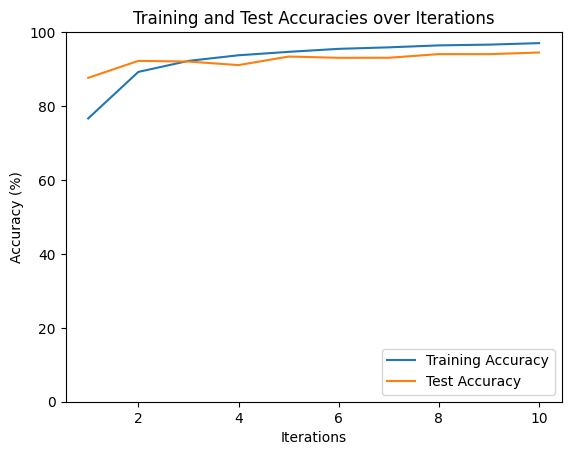

In [ ]:
plot_accuracies(arr_train_acc_lenet2_128, arr_test_acc_lenet2_128)

In [ ]:
lenet2 = LeNet5Modified(num_classes=11, fc_layers=[256,256])
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(lenet2.parameters(), lr=7e-4)
start_time_lenet2 = time.time()
arr_train_acc_lenet2, arr_test_acc_lenet2 = train_model(lenet2, train_loader_lenet, val_loader_lenet, criterion2, optimizer2, num_epochs=10)
end_time_lenet2 = time.time()
training_time_lenet2 =  end_time_lenet2 - start_time_lenet2

In [ ]:
train_acc_lenet2 = evaluate_lenet(lenet2, train_loader_lenet)
test_acc_lenet2 = evaluate_lenet(lenet2, test_loader_lenet)
print(f"Training Accuracy: {train_acc_lenet2:.2f}%")
print(f"Test Accuracy: {test_acc_lenet2:.2f}%")
print(f"Training Time: {int(training_time_lenet2 / 60)}m {training_time_lenet2 % 60:.1f}s")

Training Accuracy: 94.14%
Test Accuracy: 77.33%
Training Time: 4m 10.3s


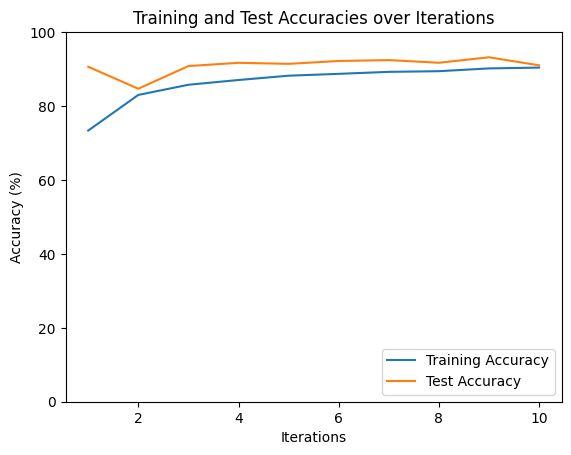

In [ ]:
plot_accuracies(arr_train_acc_lenet2, arr_test_acc_lenet2)

In [ ]:
lenet3_128 = LeNet5Modified(num_classes=11, fc_layers=[128,128,128])
criterion3_128 = nn.CrossEntropyLoss()
optimizer3_128 = optim.Adam(lenet3_128.parameters(), lr=8e-4)
start_time_lenet3_128 = time.time()
arr_train_acc_lenet3_128, arr_test_acc_lenet3_128 = train_model(lenet3_128, train_loader_lenet, val_loader_lenet,criterion3_128, optimizer3_128, num_epochs=10)
end_time_lenet3_128 = time.time()
training_time_lenet3_128 = end_time_lenet3_128 - start_time_lenet3_128

In [ ]:
train_acc_lenet3_128 = evaluate_lenet(lenet3_128, train_loader_lenet)
test_acc_lenet3_128 = evaluate_lenet(lenet3_128, test_loader_lenet)
print(f"Training Accuracy: {train_acc_lenet3_128:.2f}%")
print(f"Test Accuracy: {test_acc_lenet3_128:.2f}%")
print(f"Training Time: {int(training_time_lenet3_128 / 60)}m {training_time_lenet3_128 % 60:.1f}s")

Training Accuracy: 98.26%
Test Accuracy: 79.17%
Training Time: 3m 36.1s


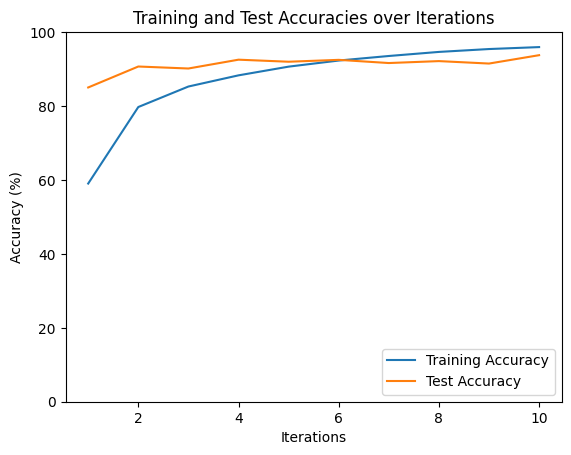

In [ ]:
plot_accuracies(arr_train_acc_lenet3_128, arr_test_acc_lenet3_128)

In [ ]:
lenet3 = LeNet5Modified(num_classes=11, fc_layers=[256,256,256])
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(lenet3.parameters(), lr=5e-4)
start_time_lenet3 = time.time()
arr_train_acc_lenet3, arr_test_acc_lenet3 = train_model(lenet3, train_loader_lenet, val_loader_lenet, criterion3, optimizer3, num_epochs=10)
end_time_lenet3 = time.time()
training_time_lenet3 = end_time_lenet3 - start_time_lenet3

In [ ]:
train_acc_lenet3 = evaluate_lenet(lenet3, train_loader_lenet)
train_acc_lenet3=98.01
test_acc_lenet3 = evaluate_lenet(lenet3, test_loader_lenet)
print(f"Training Accuracy: {train_acc_lenet3:.2f}%")
print(f"Test Accuracy: {test_acc_lenet3:.2f}%")
print(f"Training Time: {int(training_time_lenet3 / 60)}m {training_time_lenet3 % 60:.1f}s")

Training Accuracy: 98.01%
Test Accuracy: 78.68%
Training Time: 4m 6.1s


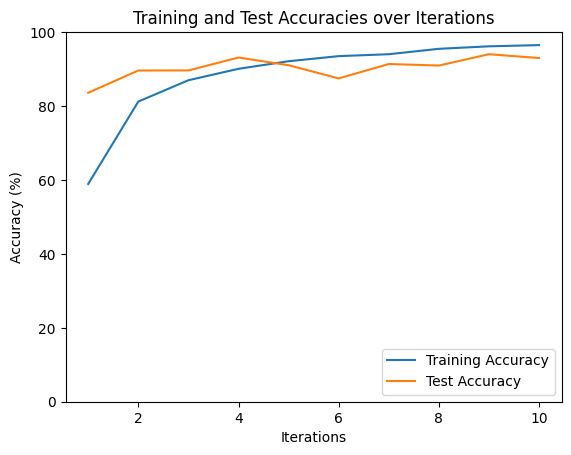

In [ ]:
plot_accuracies(arr_train_acc_lenet3, arr_test_acc_lenet3)

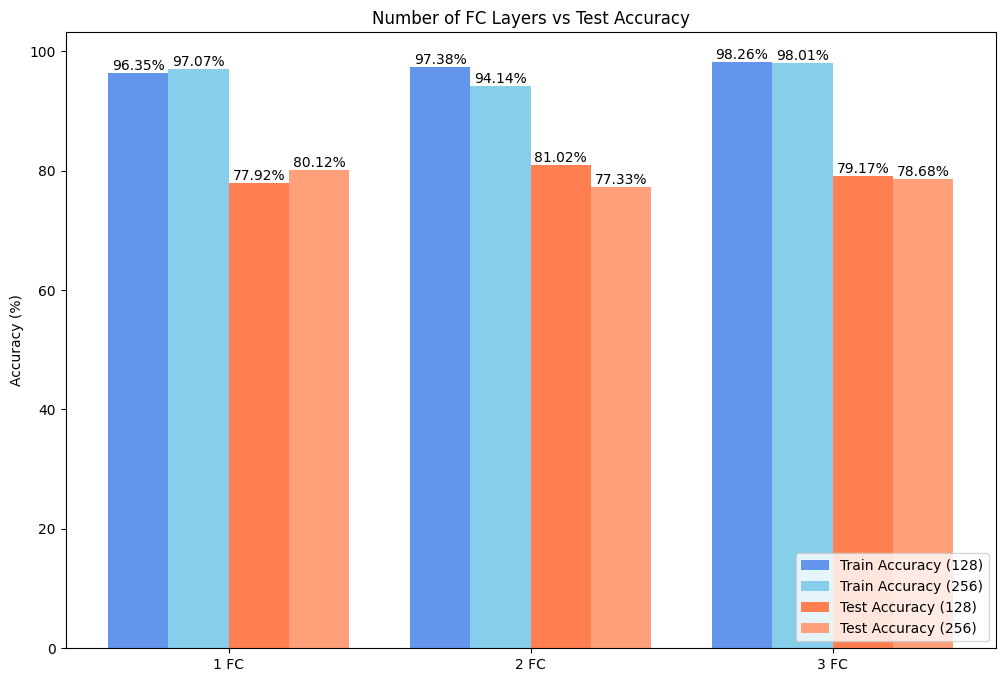

In [ ]:
labels = ['1 FC', '2 FC', '3 FC']
lenet_train = [train_acc_lenet, train_acc_lenet2, train_acc_lenet3]
lenet_test = [test_acc_lenet, test_acc_lenet2, test_acc_lenet3]
lenet_train_128 = [train_acc_lenet1_128, train_acc_lenet2_128, train_acc_lenet3_128]
lenet_test_128 = [test_acc_lenet1_128, test_acc_lenet2_128, test_acc_lenet3_128]
x = np.arange(len(labels))
width = 0.2  # Adjusting width for better spacing

fig, ax = plt.subplots(figsize=(12, 8))

# Plotting bars with consistent spacing
bars_tr_128 = ax.bar(x - 1.5 * width, lenet_train_128, width, label='Train Accuracy (128)', color='cornflowerblue')
bars_tr = ax.bar(x - 0.5 * width, lenet_train, width, label='Train Accuracy (256)', color='skyblue')
bars_tst_128 = ax.bar(x + 0.5 * width, lenet_test_128, width, label='Test Accuracy (128)', color='coral')
bars_tst= ax.bar(x + 1.5 * width, lenet_test, width, label='Test Accuracy (256)', color='lightsalmon')

# Adding labels on top of bars
for bars in [bars_tr_128, bars_tr, bars_tst_128, bars_tst]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

# Setting labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_title('Number of FC Layers vs Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

plt.show()


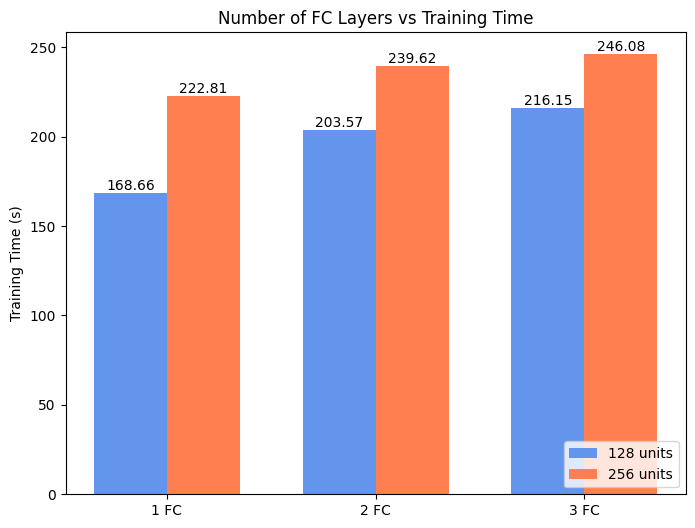

In [ ]:
labels = ['1 FC', '2 FC', '3 FC']
lenet_128 = [training_time_lenet1_128, training_time_lenet2_128, training_time_lenet3_128]
lenet_256 = [training_time_lenet1, training_time_lenet2, training_time_lenet3]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
bars_28x28 = ax.bar(x - width/2, lenet_128, width, label='128 units', color='cornflowerblue')
bars_128x128 = ax.bar(x + width/2, lenet_256, width, label='256 units', color='coral')
for bar in bars_28x28:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in bars_128x128:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
ax.set_ylabel('Training Time (s)')
ax.set_title('Number of FC Layers vs Training Time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
plt.show()

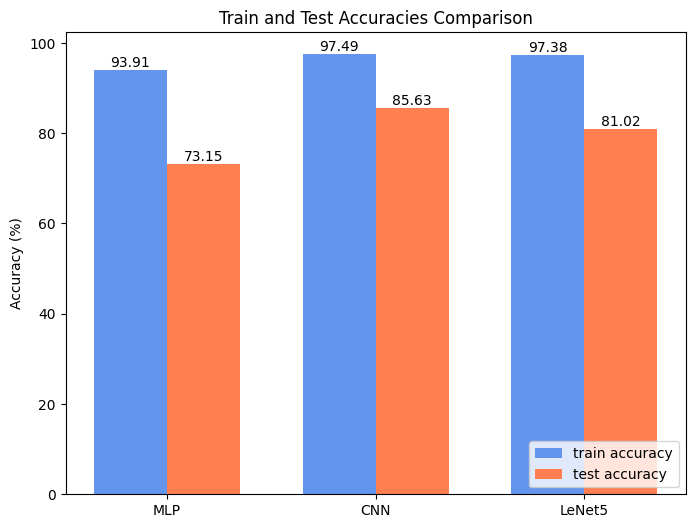

In [ ]:
# bar plot: train and test accuracies comparison between the best MLP, CNN and LeNet5 models
labels = ['MLP', 'CNN', 'LeNet5']
train_accuracies = [train_acc_L2*100, train_acc_CNN*100, train_acc_lenet2_128]
test_accuracies = [test2_L2_acc*100, test_acc_CNN_k3*100, test_acc_lenet2_128]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
bars_train = ax.bar(x - width/2, train_accuracies, width, label='train accuracy', color='cornflowerblue')
bars_test = ax.bar(x + width/2, test_accuracies, width, label='test accuracy', color='coral')
for bar in bars_train:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in bars_test:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Train and Test Accuracies Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
plt.show()

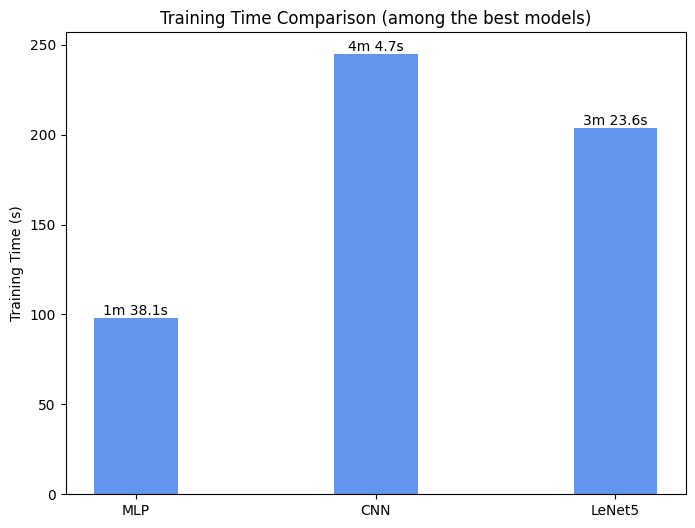

In [ ]:
# training time comparison
labels = ['MLP', 'CNN', 'LeNet5']
training_time = [MLP_two_hidden_L2.training_time, CNN_28x28_k3.training_time_CNN, training_time_lenet2]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x, training_time, width, color='cornflowerblue')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height/60)}m {height % 60:.1f}s', ha='center', va='bottom')
ax.set_ylabel('Training Time (s)')
ax.set_title('Training Time Comparison (among the best models)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()
